## Описание проекта

Нужно проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов, обращая особое внимание на отток.

Заказчиком проекта является отдел маркетинга, который хочет знать портрет клиентов, чтобы продвигать новые продукты и снизить отток. 

### План работы (декомпозиция проекта)
1. Загрузить данные
2. Привести названия столбцов к змеиному регистру
3. Проверить данные на пропуски
4. Проверить данные на явные и неявные дубликаты
5. Перевести переменные city и gender в бинарный формат
6. Изучить аномалии в данных
7. Провести категоризацию данных по значению "score", "balance", "EST_SALARY"
8. Исследовать коореляцию параметров клиентов: количество продуктов, возраст, пол и т.д.
9. Исследовать, какие признаки влияют на количество используемых продуктов
10. Проверить статистические гипотезы:
- Н0: Возраст клиентов, которые пользуются одним и двумя продуктами не отличается
- Н1: Возраст клиентов, которые пользуются одним и двумя продуктами отличается


- Н0: Отсутствие кредитных продуктов не влияет на отток клиентов
- Н1: Отсутствие кредитных продуктов влияет на отток клиентов

11. Выявить взаимосвязь между оттоком и другими параметрами в датасете.
12. Провести сегментацию пользователей на основе данных о количестве потребляемых продуктов.
13. Подвести итоги о том, что влияет на отток клиентов, сформулировать рекомендации для отдела маркетинга
14. На основе полученных данных построить дашборд и презентацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as stats

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.stats.proportion import proportions_ztest
from scipy import stats as st

In [2]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)

In [3]:
df.head()

USERID  score       city gender   age  equity     balance  products  \
0  183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1  146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2  120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3  225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4  157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  EST_SALARY  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

Приведем названия столбцов к змеиному регистру

In [4]:
df = df.rename(columns={'USERID':'user_id',
                        'EST_SALARY':'est_salary'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


### **Описание данных:**

Датасет содержит данные о клиентах банка. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `user_id` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество объектов в собственности,
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `est_salary` — заработная плата клиента,
- `churn` — ушёл или нет.

столбцы age и balance содержат пропуски, в столбце age пропусков не так много, а в столбце balance почти 2300 пропусков, нужно будет разобраться, с чем это может быть связано

для дискретных переменных построим распределение доли пропусков в balance

In [6]:
list_of_columns = ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn']

        city   balance
0     Ростов  0.165843
1    Рыбинск  0.220037
2  Ярославль  0.249151


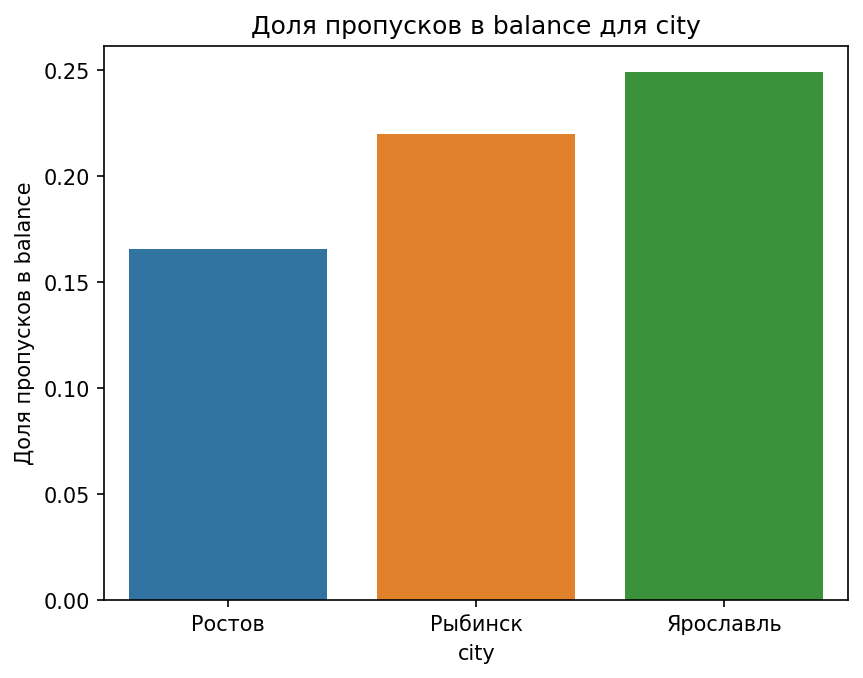

  gender   balance
0      Ж  0.202803
1      М  0.256144


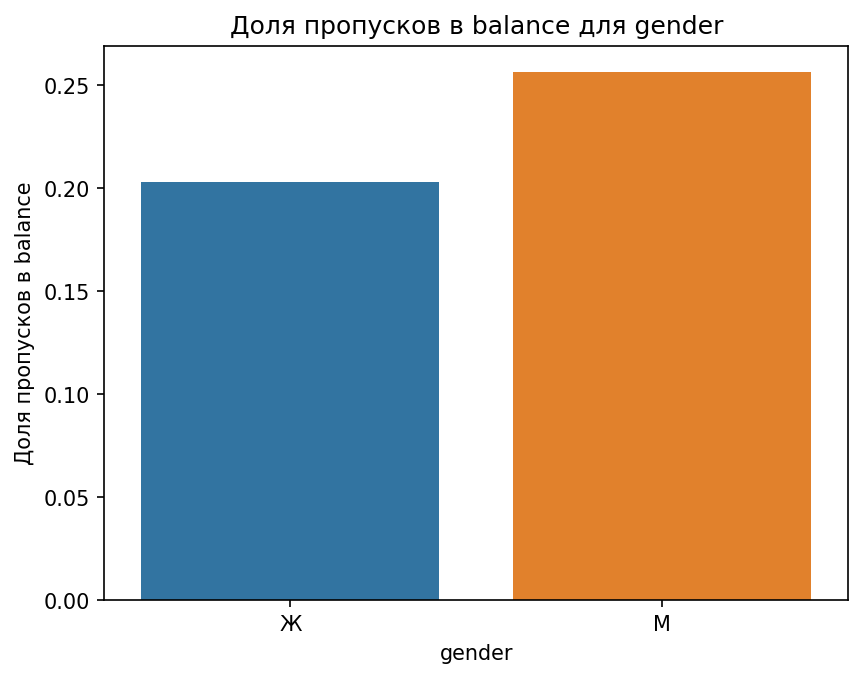

   equity   balance
0       0  0.841049
1       1  0.147287
2       2  0.000000
3       3  0.000648
4       4  0.000000
5       5  0.000000
6       6  0.000000
7       7  0.000000
8       8  0.000000
9       9  0.000000


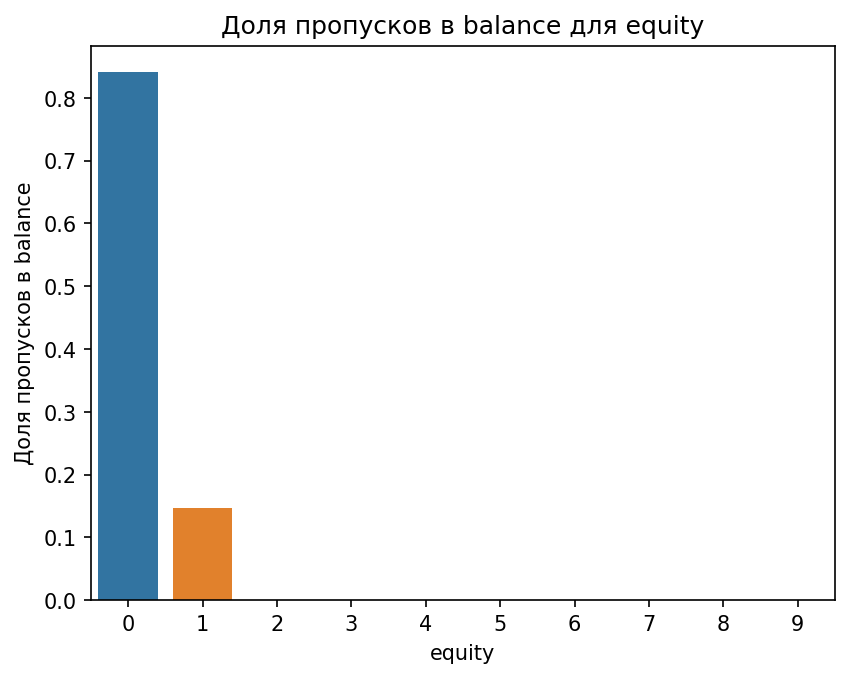

   products   balance
0         0  1.000000
1         1  0.583658
2         2  0.061451
3         3  0.027911
4         4  0.000000
5         5  0.000000


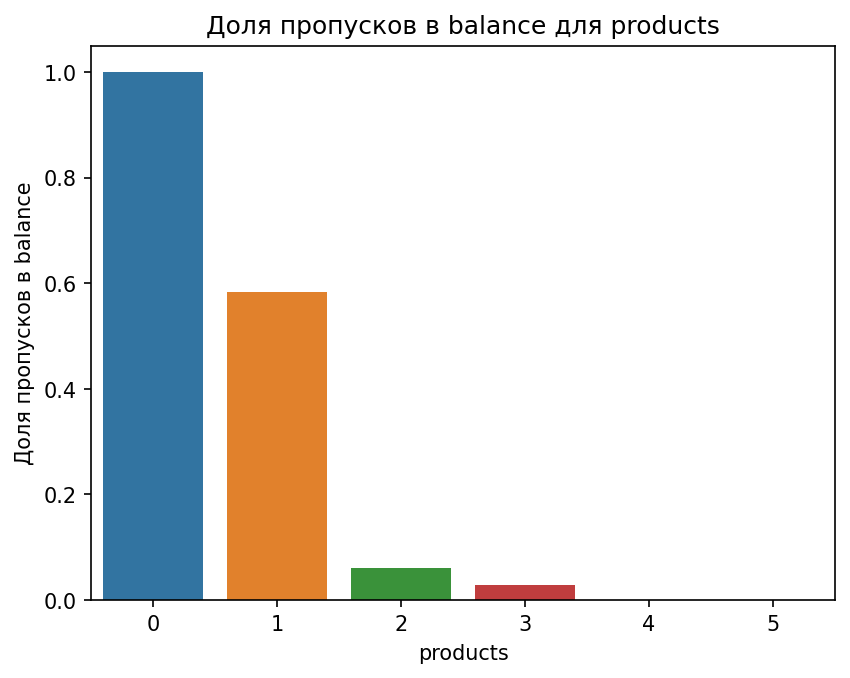

   credit_card   balance
0            0  0.132353
1            1  0.275132


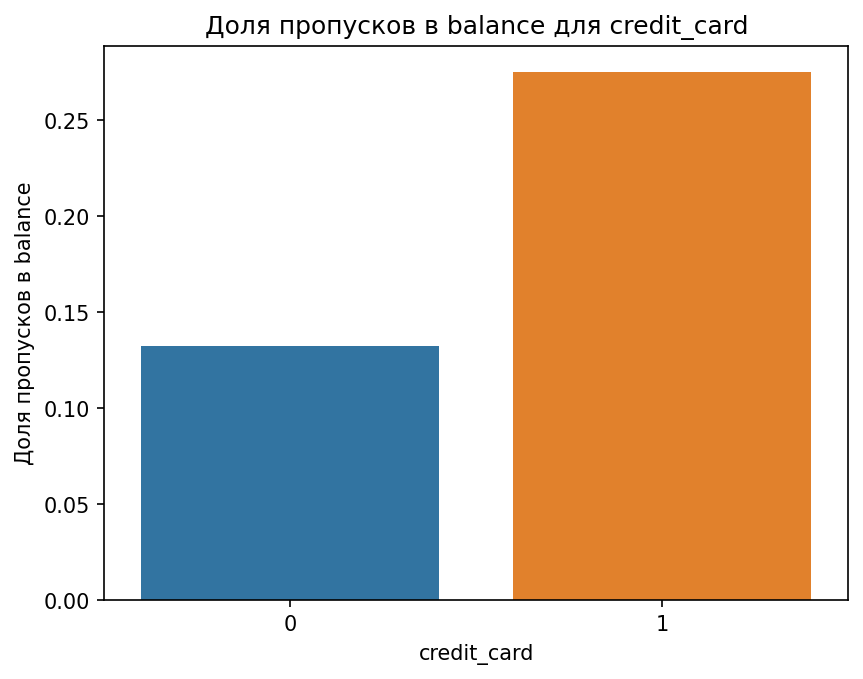

   last_activity   balance
0              0  0.216999
1              1  0.240879


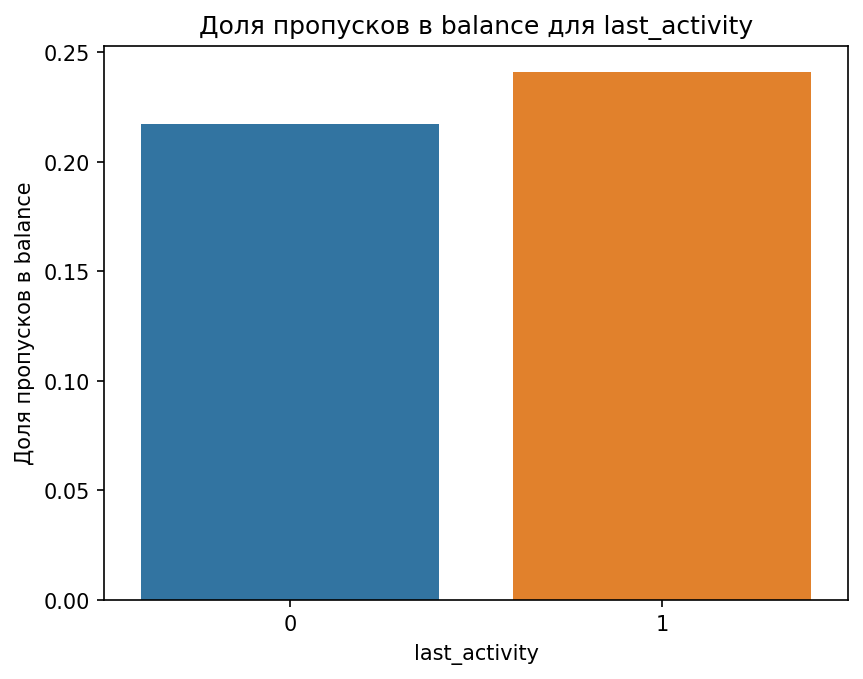

   churn   balance
0      0  0.278973
1      1  0.007143


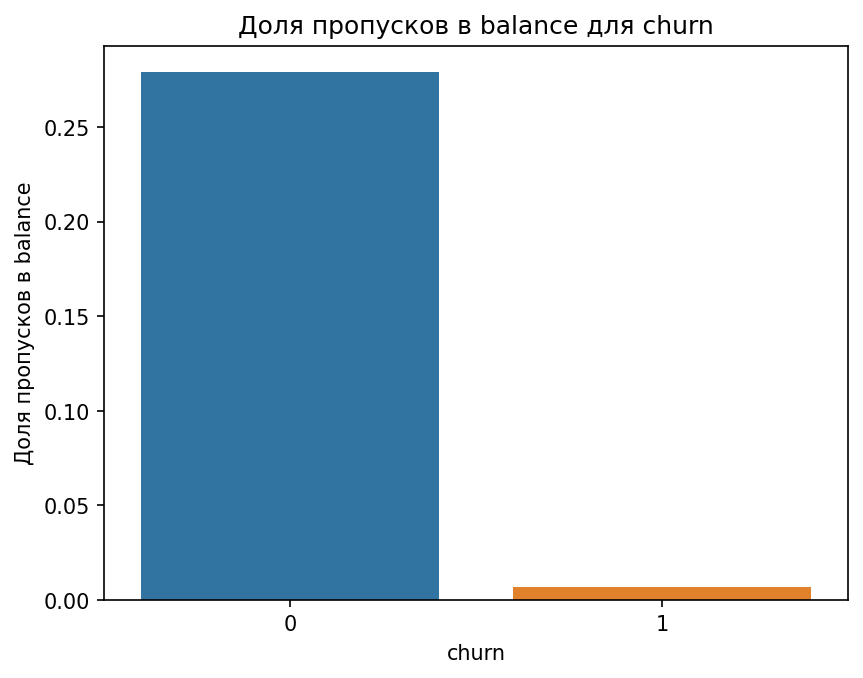

In [7]:
for column in list_of_columns:
    df_grouped=df.groupby(column).agg({'balance': lambda x: sum(x.isna()) / x.shape[0]}).reset_index()
    print(df_grouped)
    ax = sns.barplot(data=df_grouped, x=column, y='balance')
    plt.title(f'Доля пропусков в balance для {column}')
    plt.ylabel('Доля пропусков в balance')
    plt.show()

и отдельно для непрерывных переменных 

In [8]:
list_of_columns = ['score', 'age', 'est_salary']

      score  balance
0     642.0      1.0
1     646.0      1.0
2     648.0      1.0
3     649.0      1.0
4     650.0      1.0
..      ...      ...
343   996.0      0.0
344   997.0      0.0
345   998.0      0.0
346   999.0      0.0
347  1000.0      0.0

[348 rows x 2 columns]


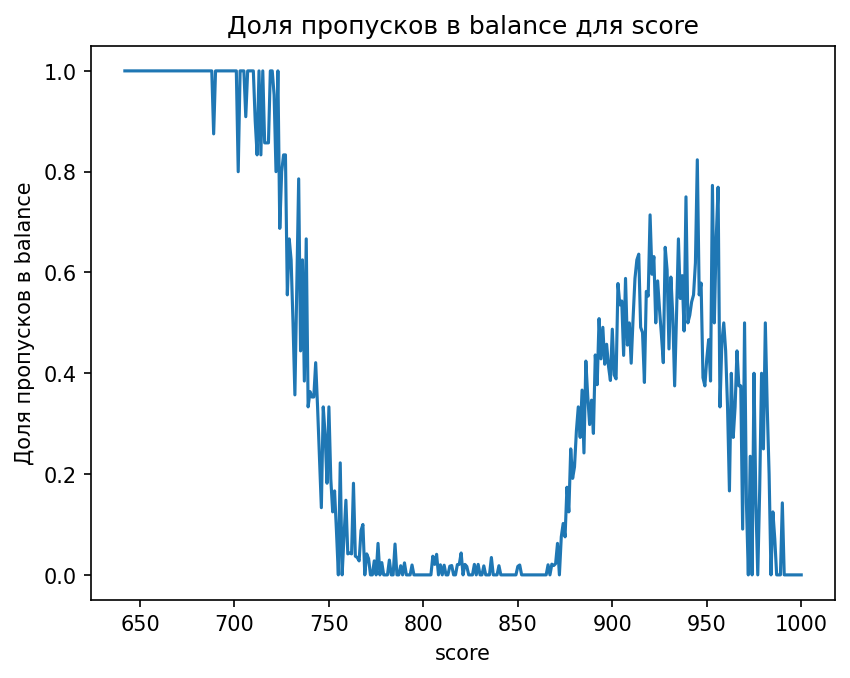

     age   balance
0   18.0  0.615385
1   19.0  0.375000
2   20.0  0.391304
3   21.0  0.333333
4   22.0  0.444444
..   ...       ...
63  81.0  0.500000
64  82.0  0.000000
65  83.0  0.333333
66  84.0  0.000000
67  86.0  0.500000

[68 rows x 2 columns]


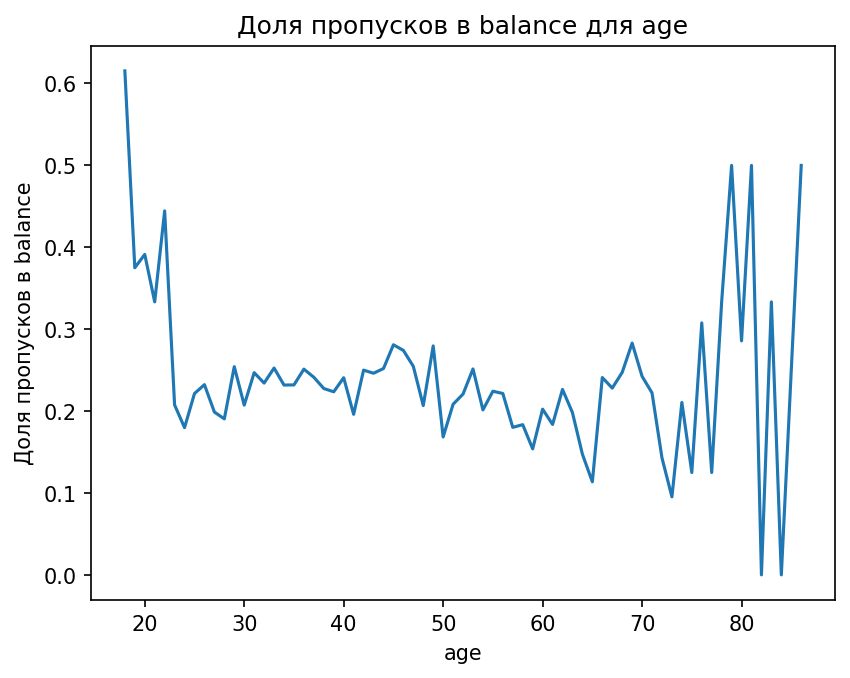

      est_salary  balance
0        2546.30      0.0
1        3487.33      0.0
2        5043.14      0.0
3        5341.50      0.0
4        7054.82      0.0
...          ...      ...
9991  1296838.08      1.0
9992  1307090.18      1.0
9993  1333687.36      1.0
9994  1363549.52      0.0
9995  1395064.45      0.0

[9996 rows x 2 columns]


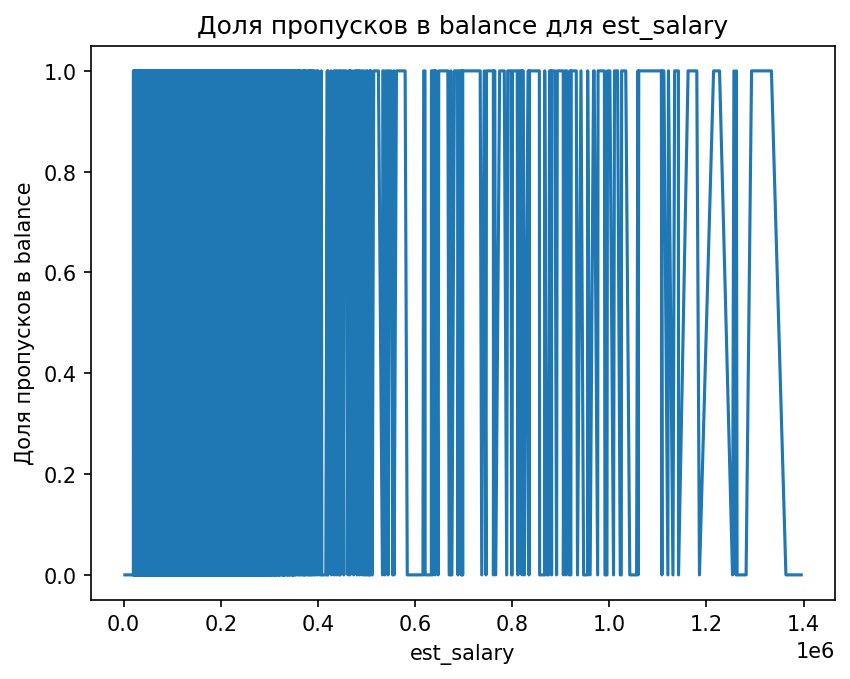

In [9]:
for column in list_of_columns:
    df_grouped=df.groupby(column).agg({'balance': lambda x: sum(x.isna()) / x.shape[0]}).reset_index()
    print(df_grouped)
    ax = sns.lineplot(data=df_grouped, x=column, y='balance')
    plt.title(f'Доля пропусков в balance для {column}')
    #ax.set_xscale(np.arange(min(df_grouped[column]), max(df_grouped[column])))
    plt.ylabel('Доля пропусков в balance')
    plt.show()

на основе полученных диаграмм можно сделать следующие выводы:
- доля пропусков в balance больше у клиентов из Ярославля, меньше всего - из Ростова, больше у мужчин, неотточных клиентов без объектов в собственности, с 0 или с 1 продуктом и при наличии кредитной карты
- значение balance отсутствует у многих пользователей со значениями score 650 - 725, а также у многих пользователей со значениями score 875 - 950
- пропусков больше у клиентов до 21 года и появляются у клиентов старше 77

Заполнять пропуски пока нет необходимости, чтобы не искажать исходные данные

In [10]:
df.duplicated(subset=None, keep='first').mean()

0.0

Явных дубликатов нет

In [11]:
df[['user_id']].duplicated(subset=None, keep='first').mean()

0.0073

есть клиенты с одинаковым user_id

In [12]:
duplicates = df.loc[df.duplicated(subset=['user_id'], keep=False)].sort_values(by='user_id', ascending=False)
duplicates

user_id  score       city gender   age  equity     balance  products  \
6457   228075  839.0    Рыбинск      М  39.0       5   507199.85         3   
1247   228075  932.0  Ярославль      М   NaN       5  7601719.20         2   
8205   227795  840.0    Рыбинск      М  34.0       2   350768.03         1   
8497   227795  839.0  Ярославль      М  34.0       2   326593.14         2   
4216   226719  903.0    Рыбинск      Ж  63.0       0         NaN         1   
...       ...    ...        ...    ...   ...     ...         ...       ...   
5896   120258  905.0  Ярославль      М  30.0       0         NaN         1   
7542   117943  880.0  Ярославль      Ж  40.0       0         NaN         1   
4866   117943  855.0    Рыбинск      Ж  32.0       6  1036832.93         4   
7694   116540  887.0  Ярославль      Ж  38.0       0         NaN         1   
1893   116540  883.0    Рыбинск      Ж  55.0       1   362756.49         3   

      credit_card  last_activity  est_salary  churn  
6457            0              1    85195.80      0  
1247            1              1   408121.16      0  
8205            1              0   102036.14      1  
8497            1              0   103314.92      0  
4216            1              0   138582.58      0  
...           ...            ...         ...    ...  
5896            1              1   146427.96      0  
7542            1              0   137718.93      0  
4866            1              1   107792.71      1  
7694            0              1   119247.61      0  
1893            0              1   175920.48      1  

[146 rows x 12 columns]

In [13]:
df[['user_id', 'city']].duplicated(subset=None, keep='first').mean()

0.0

клиенты с одинаковым user_id из разных филиалов

In [14]:
df[['user_id', 'gender']].duplicated(subset=None, keep='first').mean()

0.0041

есть небольшое свопадение по полу

In [15]:
df[['user_id', 'age']].duplicated(subset=None, keep='first').mean()

0.0005

а также по возрасту

Дублирующиеся id оставлю как есть, поскольку их очень мало и они не повлияют на результаты анализа, то же самое с пропусками в age

In [16]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

Датасет содержит данные пользователей из 3-х городов

In [17]:
df['equity'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

количество объектов в собственности от 0 до 9

In [18]:
df['products'].sort_values().unique()

array([0, 1, 2, 3, 4, 5])

у клиентов от 0 до 5 продуктов

Приведем переменные "city" в бинарный вид, создадим столбец "center". Ярославль - областной центр, клиентам из Ярославля в center будет присвоено значение True. Клиентам из Рыбинска и Ростова Великого будет присвоено значение False.

In [19]:
df['yaroslavl'] = df['city']=='Ярославль'
df['rostov'] = df['city']=='Ростов'
df['rybinsk'] = df['city']=='Рыбинск'
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  yaroslavl  rostov  rybinsk  
0            0              1    75719.14      1      False   False     True  
1            1              0    86621.77      0      False   False     True  
2            1              1   107683.34      0      False   False     True  
3            0              1   174423.53      1       True   False    False  
4            1              0    67353.16      1       True   False    False

Приведем переменные gender в бинарный вид, создадим столбец gender_new. Мужчинам присвоим значение 1, женщинам - 0

In [20]:
df['gender_new'] = df['gender'].map({'М':1, 'Ж':0})

In [21]:
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  yaroslavl  rostov  rybinsk  \
0            0              1    75719.14      1      False   False     True   
1            1              0    86621.77      0      False   False     True   
2            1              1   107683.34      0      False   False     True   
3            0              1   174423.53      1       True   False    False   
4            1              0    67353.16      1       True   False    False   

   gender_new  
0           0  
1           0  
2           0  
3           0  
4           1

### Анализ выбросов

Построим распределение переменных score, balance, est_salary   

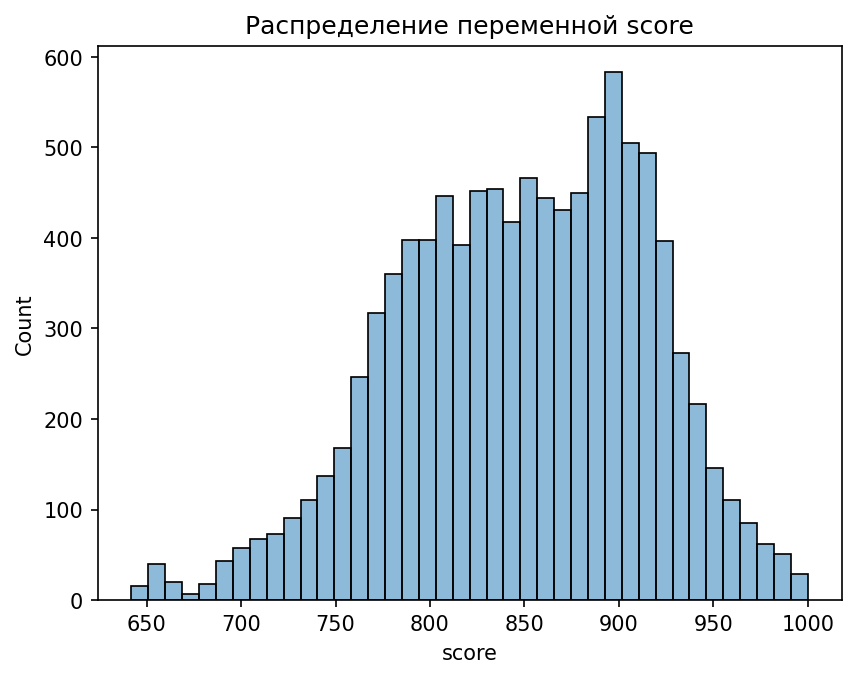

In [22]:
sns.histplot(df['score'], alpha=0.5)
plt.title('Распределение переменной score')
plt.show()

в score выбросов нет

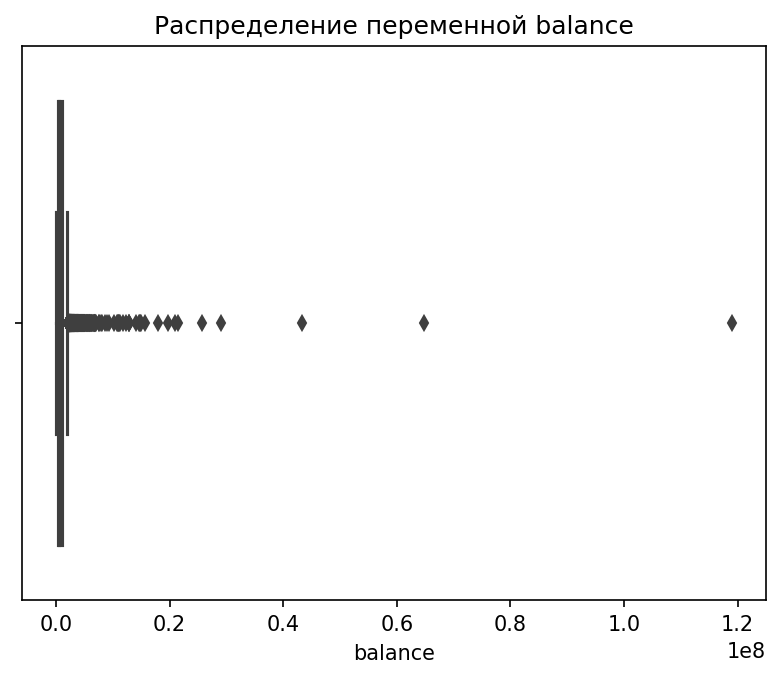

In [23]:
sns.boxplot(x = df['balance'])
plt.title('Распределение переменной balance')

plt.show()

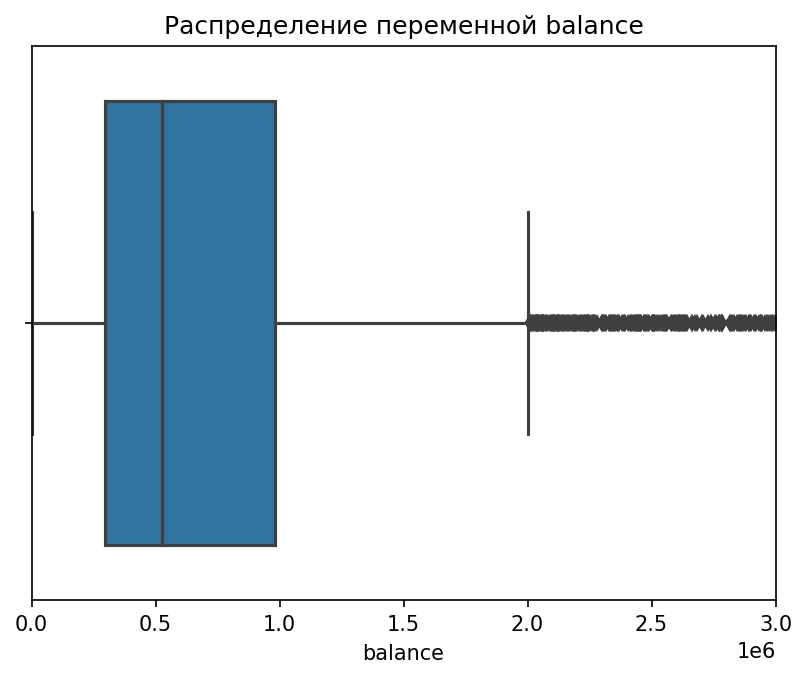

In [24]:
sns.boxplot(x = df['balance'])
plt.title('Распределение переменной balance')

plt.xlim(0,3000000)

plt.show()

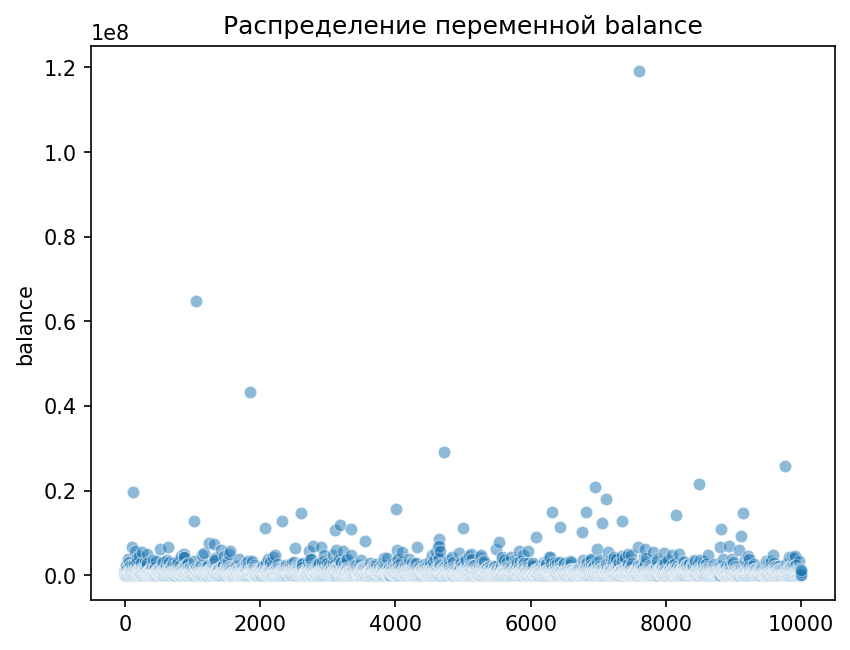

In [25]:
sns.scatterplot(data=df['balance'], alpha=0.5)
plt.title('Распределение переменной balance')
#plt.xlabel('кол-во клиентов')
plt.ylabel('balance')

plt.show()

In [26]:
df['balance'].describe()

count    7.705000e+03
mean     8.277943e+05
std      1.980614e+06
min      0.000000e+00
25%      2.955542e+05
50%      5.242722e+05
75%      9.807058e+05
max      1.191136e+08
Name: balance, dtype: float64

в balance есть очень большие значения, на 3 порядка отличающиеся от медианной величины, но это необязательно выбросы или аномалии, а вполне могут быть реальными данными, удалять их не нужно 

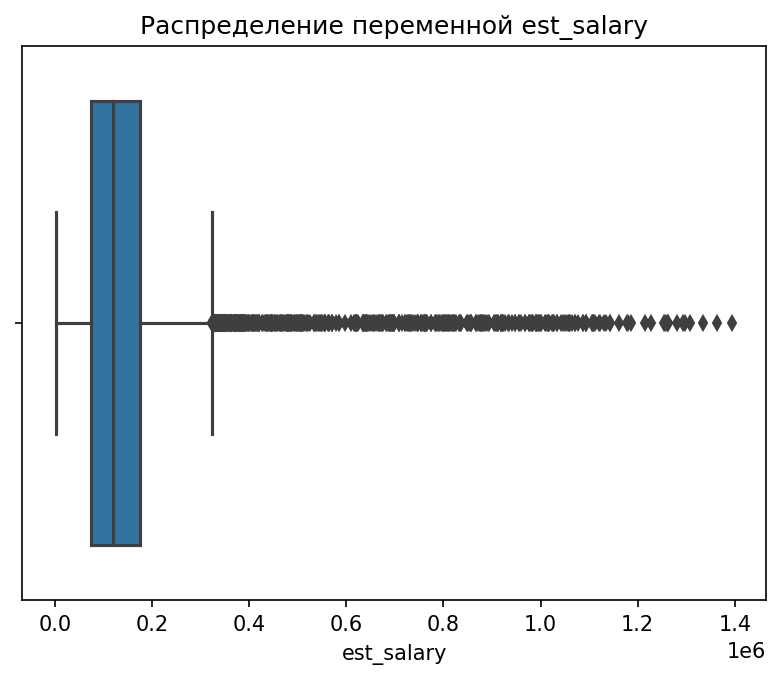

In [27]:
sns.boxplot(x = df['est_salary'])
plt.title('Распределение переменной est_salary')

#plt.ylabel('est_salary')
plt.show()

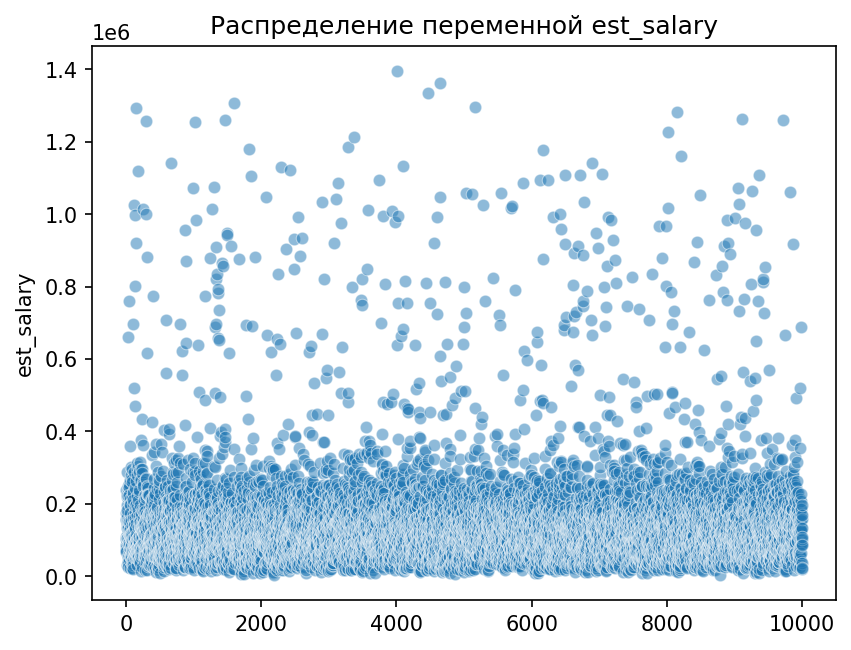

In [28]:
sns.scatterplot(data = df['est_salary'],alpha=0.5)
plt.title('Распределение переменной est_salary')

plt.show()

In [29]:
df['est_salary'].describe()

count    1.000000e+04
mean     1.478669e+05
std      1.393885e+05
min      2.546300e+03
25%      7.525190e+04
50%      1.196581e+05
75%      1.745005e+05
max      1.395064e+06
Name: est_salary, dtype: float64

в est_salary также есть большие значения, на порядок отличающиеся от медианной величины, но это похоже на реальные  данные, удалять их не буду

Сделаем категоризацию переменной score, для этого можно разбить score на 5 диапазонов 

In [30]:
df['score_cut'] = pd.cut(df['score'],5)

In [31]:
t=df.groupby('score_cut',dropna=False)['score'].agg(['count']).reset_index(drop=False)
t

score_cut  count
0  (641.642, 713.6]    267
1    (713.6, 785.2]   1502
2    (785.2, 856.8]   3423
3    (856.8, 928.4]   3835
4   (928.4, 1000.0]    973

Присвоим каждому интервалу значение

In [32]:
def score_category(score):
    try:
        if  score <= 714:
            return 'E'
        elif 714 < score <= 786:
            return 'D'
        elif 786 < score <= 857:
            return 'C'
        elif 857 < score <= 928:
            return 'B'
        elif score >= 928:
            return 'A'
    except:
        pass

In [33]:
df['score_category'] = df['score'].apply(score_category)
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  yaroslavl  rostov  rybinsk  \
0            0              1    75719.14      1      False   False     True   
1            1              0    86621.77      0      False   False     True   
2            1              1   107683.34      0      False   False     True   
3            0              1   174423.53      1       True   False    False   
4            1              0    67353.16      1       True   False    False   

   gender_new       score_cut score_category  
0           0  (785.2, 856.8]              C  
1           0  (856.8, 928.4]              B  
2           0  (856.8, 928.4]              B  
3           0  (856.8, 928.4]              B  
4           1  (713.6, 785.2]              D

Категоризацию переменной balance произведем по квартилям, отдельно выделив очень большие значения

In [34]:
df_filtered = df.query('balance <=10000000')

In [35]:
def balance_category(balance):
    try:
        if 0 <= balance <= int(np.percentile(df_filtered['balance'], [25])):
            return 'E'
        elif int(np.percentile(df_filtered['balance'], [25])) < balance <= int(np.percentile(df_filtered['balance'], [50])):
            return 'D'
        elif int(np.percentile(df_filtered['balance'], [50])) < balance <= int(np.percentile(df_filtered['balance'], [75])):
            return 'C'
        elif int(np.percentile(df_filtered['balance'], [75])) < balance <= 10000000:
            return 'B'
        elif balance >= 10000000:
            return 'A'
    except:
        pass

In [36]:
df['balance_category'] = df['balance'].apply(balance_category)
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  yaroslavl  rostov  rybinsk  \
0            0              1    75719.14      1      False   False     True   
1            1              0    86621.77      0      False   False     True   
2            1              1   107683.34      0      False   False     True   
3            0              1   174423.53      1       True   False    False   
4            1              0    67353.16      1       True   False    False   

   gender_new       score_cut score_category balance_category  
0           0  (785.2, 856.8]              C                E  
1           0  (856.8, 928.4]              B                C  
2           0  (856.8, 928.4]              B             None  
3           0  (856.8, 928.4]              B                B  
4           1  (713.6, 785.2]              D                E

Аналогично сделаем категоризацию est_salary, выделив в отдельную категорию значения больше 500 тыс

In [37]:
df_filtered = df.query('est_salary <= 500000')

In [38]:
def est_salary_category(est_salary):
    try:
        if 0 <= est_salary <= int(np.percentile(df_filtered['est_salary'], [25])):
            return 'E'
        elif int(np.percentile(df_filtered['est_salary'], [25])) < est_salary <= int(np.percentile(df_filtered['est_salary'], [50])):
            return 'D'
        elif int(np.percentile(df_filtered['est_salary'], [50])) < est_salary <= int(np.percentile(df_filtered['est_salary'], [75])):
            return 'C'
        elif int(np.percentile(df_filtered['est_salary'], [75])) < est_salary <= 500000:
            return 'B'
        elif est_salary > 500000:
            return 'A'
    except:
        pass

In [39]:
df['est_salary_category'] = df['est_salary'].apply(est_salary_category)
df.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  yaroslavl  rostov  rybinsk  \
0            0              1    75719.14      1      False   False     True   
1            1              0    86621.77      0      False   False     True   
2            1              1   107683.34      0      False   False     True   
3            0              1   174423.53      1       True   False    False   
4            1              0    67353.16      1       True   False    False   

   gender_new       score_cut score_category balance_category  \
0           0  (785.2, 856.8]              C                E   
1           0  (856.8, 928.4]              B                C   
2           0  (856.8, 928.4]              B             None   
3           0  (856.8, 928.4]              B                B   
4           1  (713.6, 785.2]              D                E   

  est_salary_category  
0                   D  
1                   D  
2                   D  
3                   B  
4                   E

In [40]:
df.groupby('est_salary_category', dropna=False)['user_id'].count()

est_salary_category
A     267
B    2434
C    2433
D    2433
E    2433
Name: user_id, dtype: int64

In [41]:
df.groupby('balance_category', dropna=False)['user_id'].count()

balance_category
A        27
B      1920
C      1919
D      1920
E      1919
NaN    2295
Name: user_id, dtype: int64

In [42]:
df.groupby('score_category', dropna=False)['user_id'].count()

score_category
A     973
B    3790
C    3435
D    1523
E     279
Name: user_id, dtype: int64

Категоризация данных произведена 

### Рассмотрим матрицу корреляций признаков

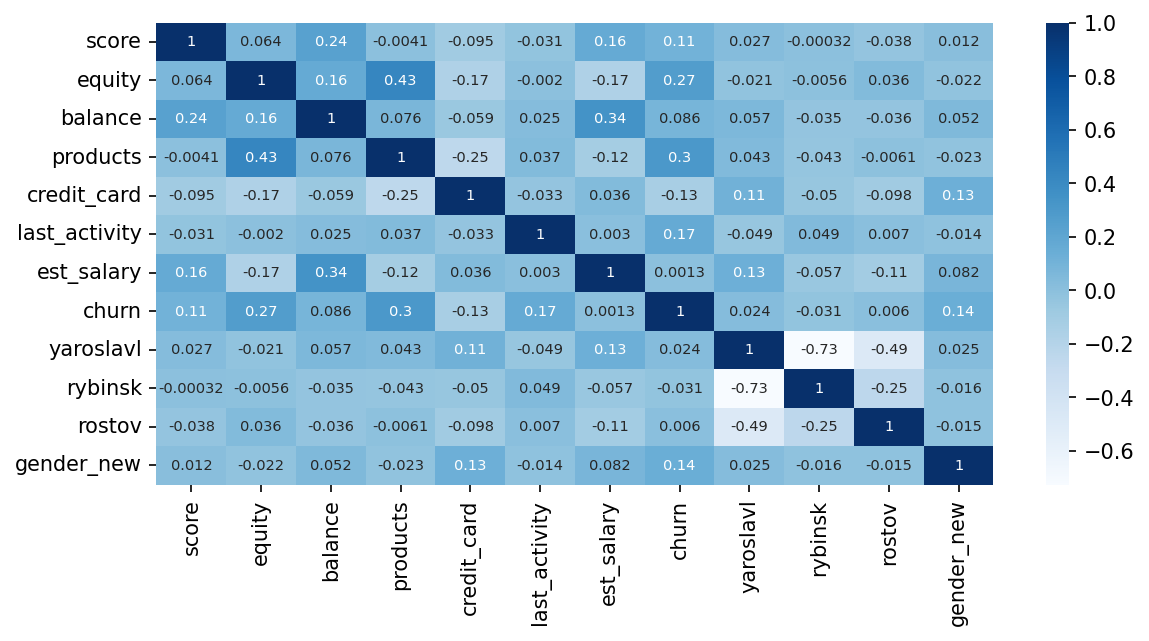

In [43]:
plt.figure(figsize=(9, 4))
sns.heatmap(df[['score', 'equity', 'balance','products', 'credit_card',
                'last_activity', 'est_salary', 'churn', 'yaroslavl', 'rybinsk', 'rostov', 'gender_new']].corr(),
            cmap="Blues", annot=True, annot_kws={'size': 7})

plt.show()



сильной, высокой и заметной корреляции между параметрами не наблюдается.

умеренная корреляция [0.3-0.5) наблюдается между:
- products и equity
- products и churn
- est_salary и balance 

слабая корреляция (0.1 до 0.3) наблюдается между:
- score с balance, est_salary, churn
- equity с balance, churn, est_salary (отрицательная)
- products c est_salary
- credit_card c products, equity, churn (везде отрицательная), yaroslavl, gender_new (положительная)
- last_activity c churn
- yaroslavl с est_salary
- churn с gender_new

Отрицательная корреляция между городами ни о чем не говорит.

### Рассмотрим зависимость количества продуктов от признаков equity и churn

In [44]:
products = df.groupby('products', as_index=False).agg({'user_id':'count', 'churn':'mean', 'equity':'mean'}) #.sort_values(by='user_id', ascending=False)
products

products  user_id     churn    equity
0         0        1  1.000000  3.000000
1         1     3341  0.070338  1.324753
2         2     5126  0.190987  3.151190
3         3     1039  0.285852  3.518768
4         4      474  0.632911  4.151899
5         5       19  0.421053  3.684211

Как видно обнаруженная корреляция подтверждается - чем больше продуктов, тем выше доля отточных клиентов, та же самая тенденция для количества объектов в собственности, при этом сами сегменты становятся меньше. Пользователей совсем без продуктов и с 5 продуктами в расчет можно не брать, так как их очень мало. 

In [45]:
products = products.query('0<products<5')
products

products  user_id     churn    equity
1         1     3341  0.070338  1.324753
2         2     5126  0.190987  3.151190
3         3     1039  0.285852  3.518768
4         4      474  0.632911  4.151899

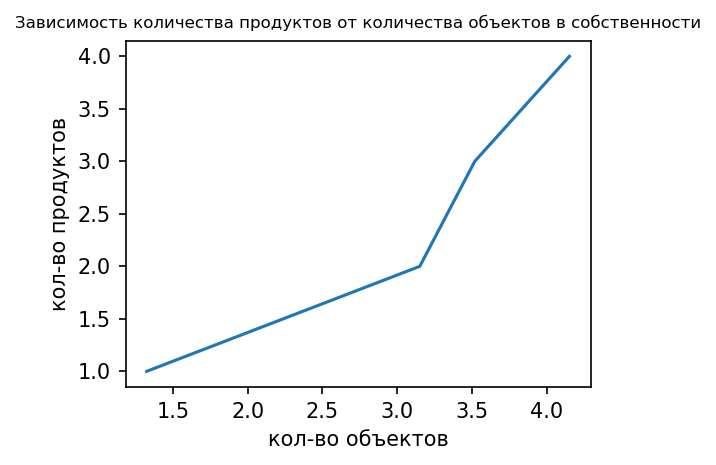

In [46]:
plt.figure(figsize=(4, 3))
sns.lineplot(y= products['products'], x=products['equity'])

plt.title('Зависимость количества продуктов от количества объектов в собственности', fontsize=8)
plt.xlabel('кол-во объектов')
plt.ylabel('кол-во продуктов')
plt.show()

Исследование оттока будет приведено ниже

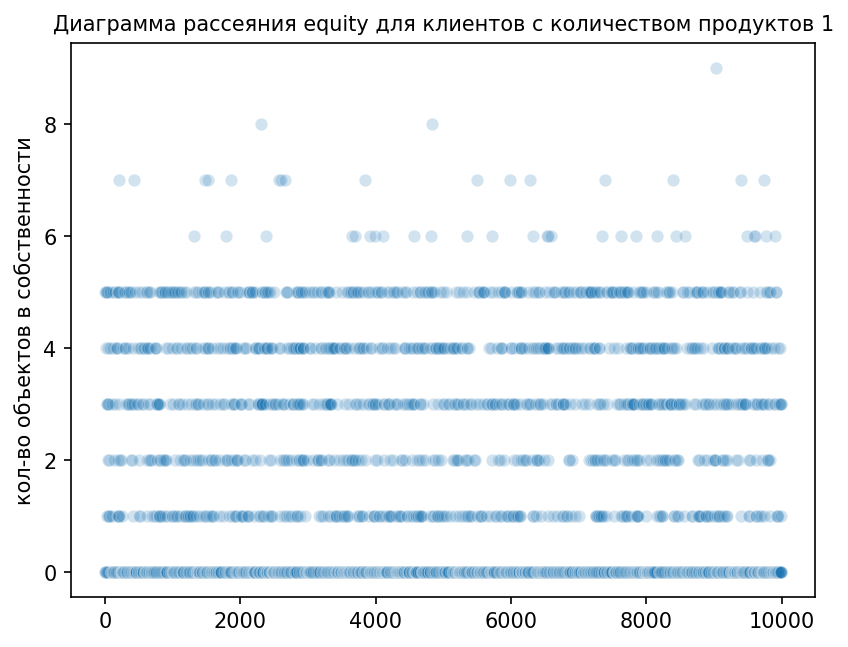

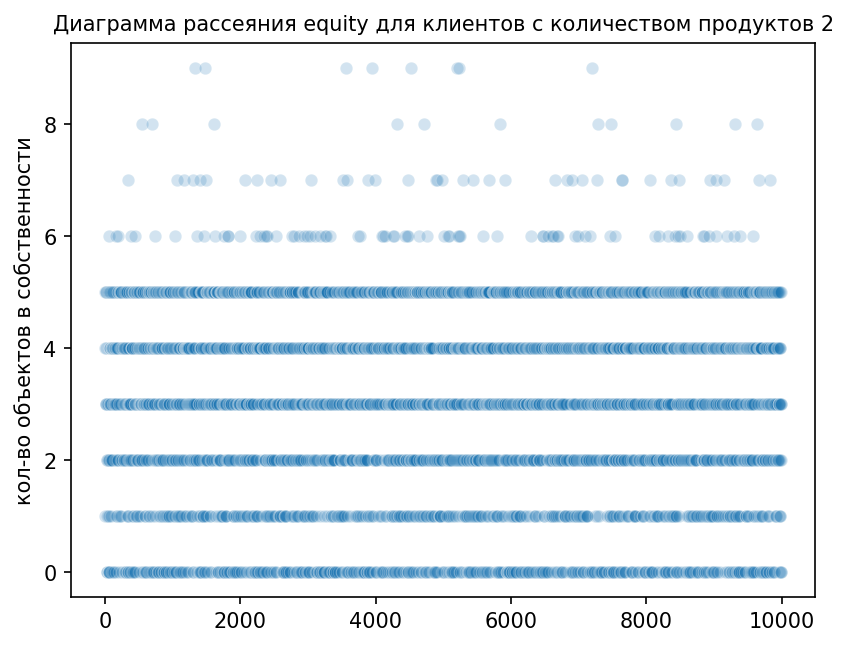

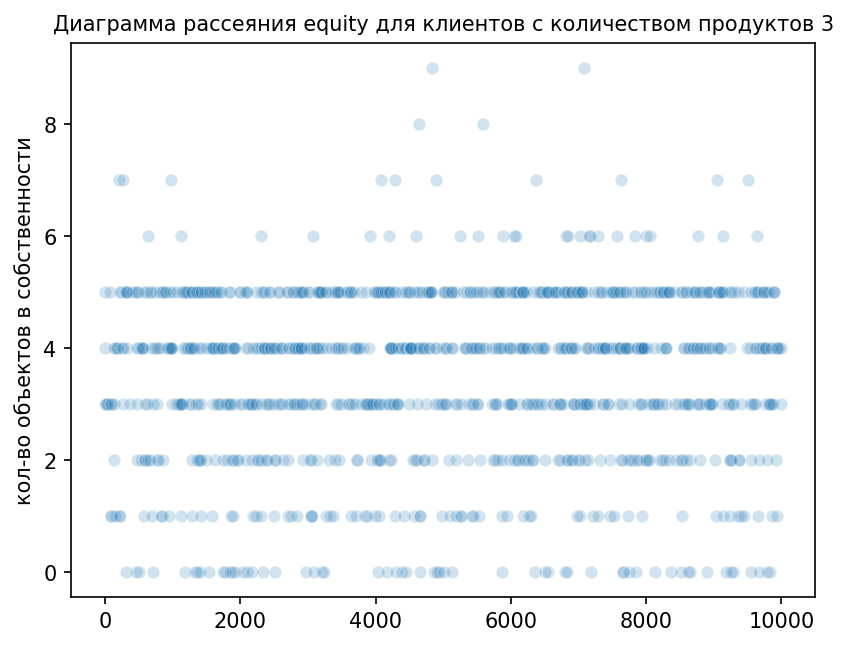

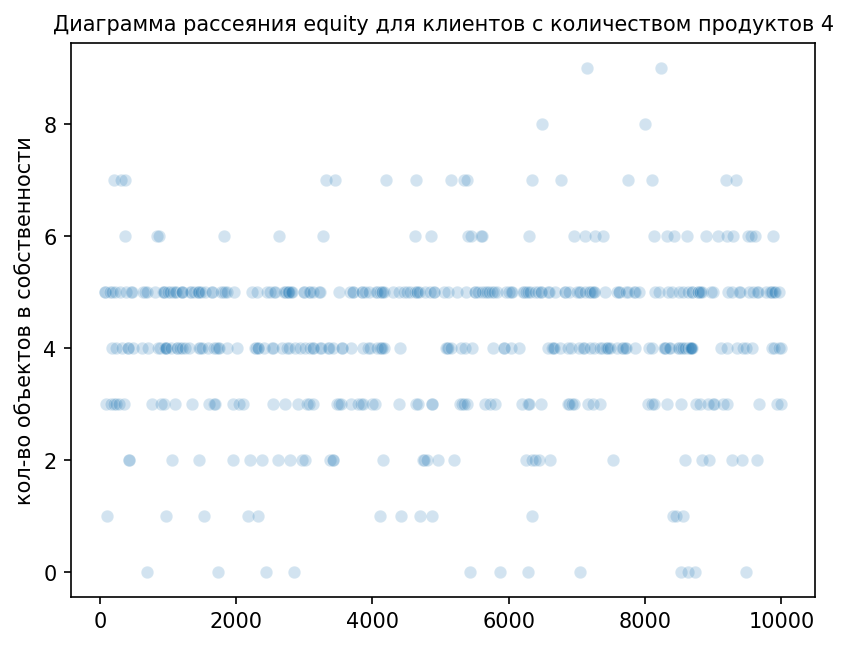

In [47]:
products_count = [1,2,3,4]
for value in products_count:
    sns.scatterplot(data = df.query('0<products<5 & products==@value')['equity'], alpha = 0.2)

    plt.title('Диаграмма рассеяния equity для клиентов с количеством продуктов {}'.format(value), fontsize=10)
    plt.ylabel('кол-во объектов в собственности')
    plt.show()

На диаграммах рассеяния виден рост количества объектов в собственности с увеличением количества продуктов с 1 до 4

    - для клиентов с 1 продуктом количество объектов в собственности варьируется от 0 до 5
    
    - с 2 продуктами также от 0 до 5
    
    - с 3 продуктами - от 2 до 4
    
    - с 4 продуктами от 4 до 5 

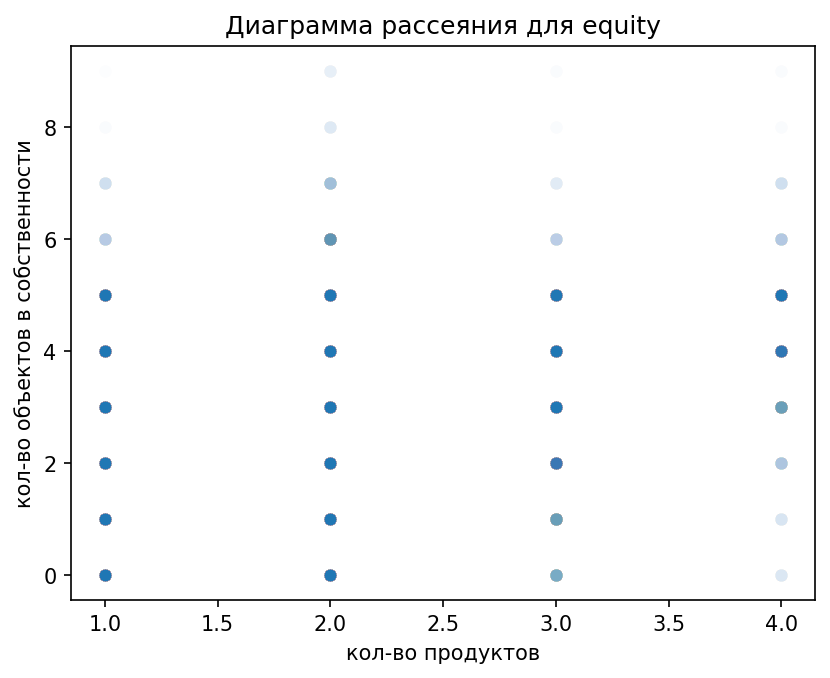

In [48]:
sns.scatterplot(x = df.query('0<products<5')['products'], y= df['equity'], alpha =0.01)
plt.title('Диаграмма рассеяния для equity')
plt.ylabel('кол-во объектов в собственности')
plt.xlabel('кол-во продуктов')
plt.show()

### Проверка гипотез

#### Гипотеза о влиянии возраста на количество продуктов

- Н0: Возраст клиентов, которые пользуются одним и двумя продуктами не отличается
- Н1: Возраст клиентов, которые пользуются одним и двумя продуктами отличается

сначала удалим данные с пропусками в age

In [49]:
df1=df.dropna(subset=['age'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   user_id              9974 non-null   int64   
 1   score                9974 non-null   float64 
 2   city                 9974 non-null   object  
 3   gender               9974 non-null   object  
 4   age                  9974 non-null   float64 
 5   equity               9974 non-null   int64   
 6   balance              7695 non-null   float64 
 7   products             9974 non-null   int64   
 8   credit_card          9974 non-null   int64   
 9   last_activity        9974 non-null   int64   
 10  est_salary           9974 non-null   float64 
 11  churn                9974 non-null   int64   
 12  yaroslavl            9974 non-null   bool    
 13  rostov               9974 non-null   bool    
 14  rybinsk              9974 non-null   bool    
 15  gender_new           

In [50]:
sample_1 = df1.query('products==1')['age']
sample_1.describe()

count    3323.000000
mean       42.196208
std        11.986899
min        18.000000
25%        33.000000
50%        40.000000
75%        49.500000
max        86.000000
Name: age, dtype: float64

In [51]:
sample_2 = df1.query('products==2')['age']
sample_2.describe()

count    5119.000000
mean       42.768900
std        12.157617
min        18.000000
25%        33.000000
50%        40.000000
75%        52.000000
max        84.000000
Name: age, dtype: float64

в выборке разное количество клиентов, проверим распределение данных в выборках

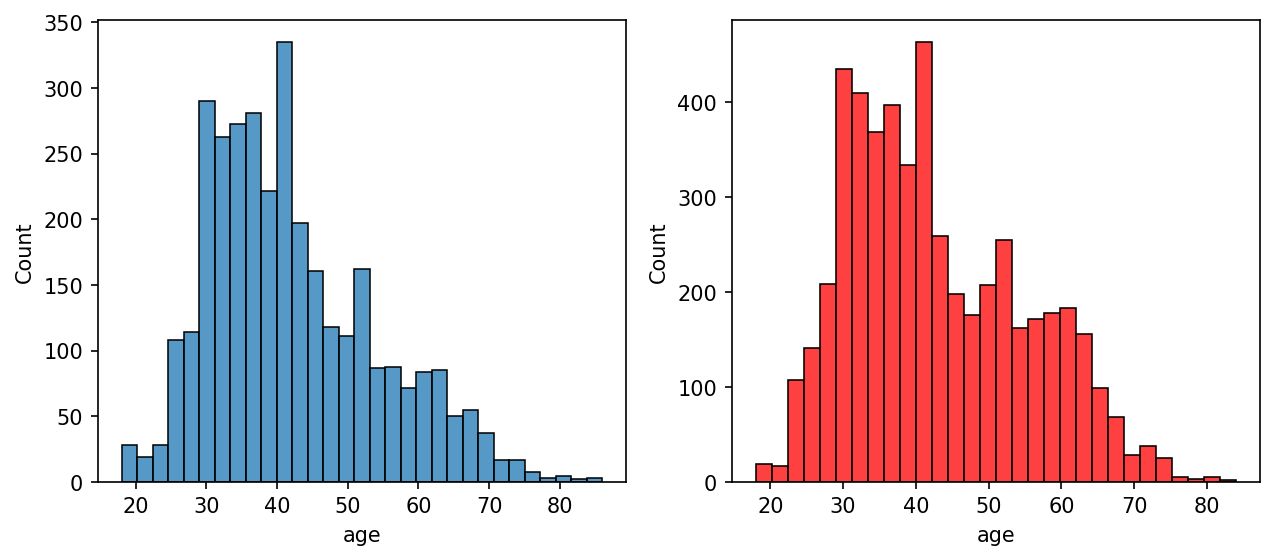

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(sample_1, ax=axes[0])
sns.histplot(sample_2, color="red" , ax=axes[1])

plt.show()

Распределение имеет вид, близкий к нормальному со смещением влево. Поскольку у нас разное количество данных в выборках, применим t-test с equal_var=False, зададим уровень статистической значимости 0.05. 

In [53]:
alpha = 0.05

results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-value:', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.03299080704232691
Отвергаем нулевую гипотезу


**отвергаем гипотезу о том, что нет разницы в возрасте между клиентами с одним и двумя продуктами**

#### Гипотеза о влиянии среднего дохода на на наличие кредита

- Н0: Зароботные платы клиентов с кредитом и без равны
- Н1: Зароботные платы клиентов с кредитом и без отличаются

In [54]:
sample_3 = df.query('credit_card==1')['est_salary']
sample_3.describe()

count    6.804000e+03
mean     1.512634e+05
std      1.465445e+05
min      2.546300e+03
25%      7.547657e+04
50%      1.209588e+05
75%      1.763525e+05
max      1.333687e+06
Name: est_salary, dtype: float64

In [55]:
sample_4 = df.query('credit_card==0')['est_salary']
sample_4.describe()

count    3.196000e+03
mean     1.406359e+05
std      1.224810e+05
min      3.487330e+03
25%      7.501535e+04
50%      1.164495e+05
75%      1.704915e+05
max      1.395064e+06
Name: est_salary, dtype: float64

размеры выборки отличаются в 2 раза

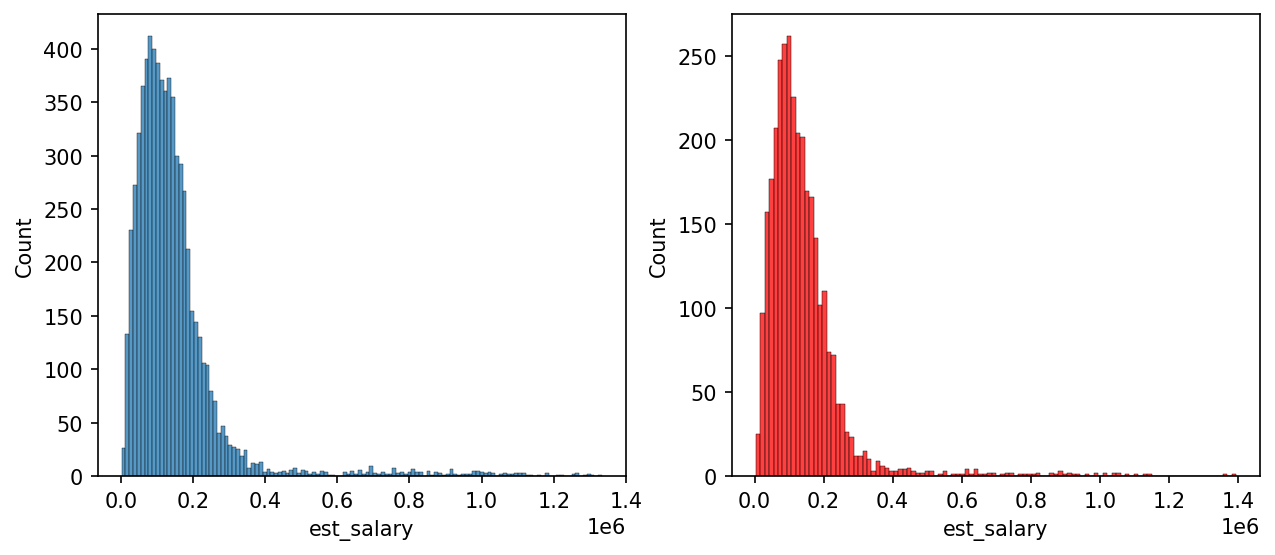

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(sample_3, ax=axes[0])
sns.histplot(sample_4, color="red" , ax=axes[1])

plt.show()

распределение нормальное в обеих выборках, но есть хвосты с очень большими значениями в est_salary

In [57]:
alpha = .05

results = st.ttest_ind(sample_3, sample_4, equal_var=False)
print('p-value:', results[1]) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.00014997646456952243
Отвергаем нулевую гипотезу


**Отвергаем нулевую гипотезу о том что зароботные платы клиентов с кредитом и без равны**

Уберем выбросы и снова проверим гипотезу

In [58]:
sample_3 = df.query('credit_card==1 & est_salary < 400000')['est_salary'] 
sample_4 = df.query('credit_card==0 & est_salary < 400000')['est_salary']

In [59]:
sample_3.describe()

count      6555.000000
mean     127821.223606
std       71288.991009
min        2546.300000
25%       73844.035000
50%      117835.340000
75%      168860.785000
max      398103.400000
Name: est_salary, dtype: float64

In [60]:
sample_4.describe()

count      3108.000000
mean     124792.407555
std       68625.310777
min        3487.330000
25%       74101.465000
50%      114588.615000
75%      164476.740000
max      399043.430000
Name: est_salary, dtype: float64

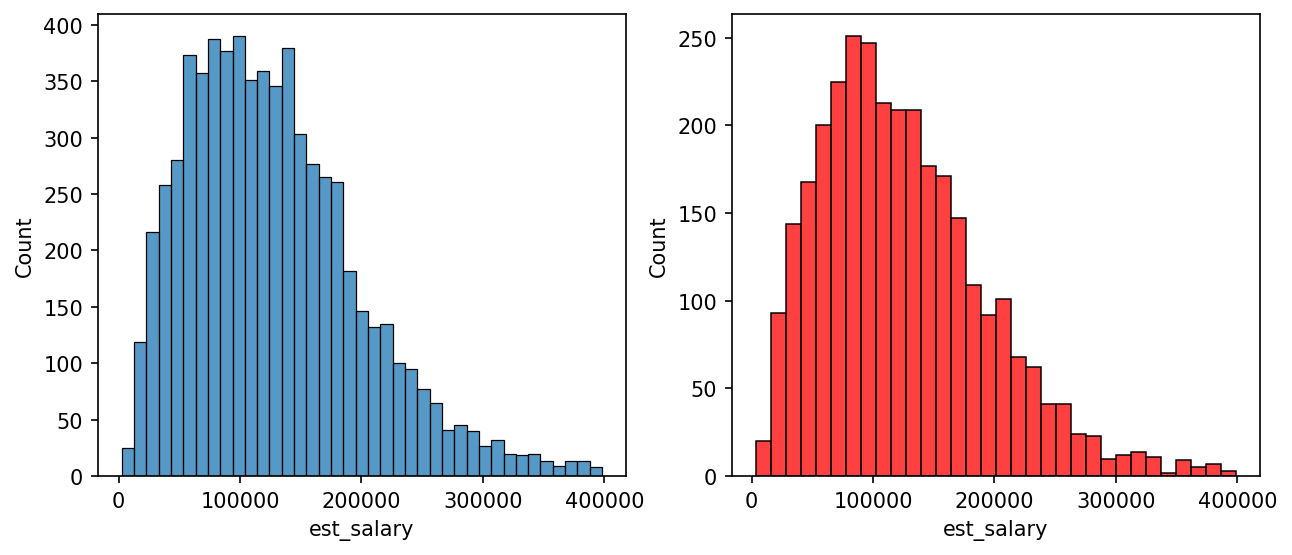

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(sample_3, ax=axes[0])
sns.histplot(sample_4, color="red" , ax=axes[1])

plt.show()

In [62]:
alpha = .05

results = st.ttest_ind(sample_3, sample_4, equal_var=False)
print('p-value:', results[1]) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.04540809127071117
Отвергаем нулевую гипотезу


Значение p-value после отброса хвостов уже на грани уровеня статистической значимости, но нулевую гипотезу все равно отвергаем

## Проведём исследование оттока

In [63]:
churn = df.query('churn==1')
display(churn.info(), churn.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 9994
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   user_id              1820 non-null   int64   
 1   score                1820 non-null   float64 
 2   city                 1820 non-null   object  
 3   gender               1820 non-null   object  
 4   age                  1819 non-null   float64 
 5   equity               1820 non-null   int64   
 6   balance              1807 non-null   float64 
 7   products             1820 non-null   int64   
 8   credit_card          1820 non-null   int64   
 9   last_activity        1820 non-null   int64   
 10  est_salary           1820 non-null   float64 
 11  churn                1820 non-null   int64   
 12  yaroslavl            1820 non-null   bool    
 13  rostov               1820 non-null   bool    
 14  rybinsk              1820 non-null   bool    
 15  gender_new           

None

user_id  score       city gender   age  equity     balance  products  \
0    183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
3    225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4    157978  730.0  Ярославль      М  34.0       5      174.00         1   
12   132970  845.0  Ярославль      Ж  31.0       3   591928.52         2   
40   129705  811.0    Рыбинск      М  34.0       2   129799.35         1   

    credit_card  last_activity  est_salary  churn  yaroslavl  rostov  rybinsk  \
0             0              1    75719.14      1      False   False     True   
3             0              1   174423.53      1       True   False    False   
4             1              0    67353.16      1       True   False    False   
12            1              1   112697.16      1       True   False    False   
40            0              0    96242.71      1      False   False     True   

    gender_new       score_cut score_category balance_category  \
0            0  (785.2, 856.8]              C                E   
3            0  (856.8, 928.4]              B                B   
4            1  (713.6, 785.2]              D                E   
12           0  (785.2, 856.8]              C                C   
40           1  (785.2, 856.8]              C                E   

   est_salary_category  
0                    D  
3                    B  
4                    E  
12                   D  
40                   D

проверим связь оттока с параметрами:

In [64]:
list_of_columns = [
    'city',
 'equity',
 'products',
 'credit_card',
 'last_activity',
 'yaroslavl', 'rostov', 'rybinsk',
 'gender_new',
 'score_category',
 'balance_category',
 'est_salary_category'
                  ]

In [65]:
for column in list_of_columns:
    df_grouped = df.groupby(column, as_index=False, dropna=False)['churn'].mean()
    print(df_grouped)
    print('__________')

        city     churn
0     Ростов  0.187721
1    Рыбинск  0.162152
2  Ярославль  0.189708
__________
   equity     churn
0       0  0.034722
1       1  0.120155
2       2  0.157795
3       3  0.208684
4       4  0.250811
5       5  0.300834
6       6  0.360248
7       7  0.462500
8       8  0.352941
9       9  0.538462
__________
   products     churn
0         0  1.000000
1         1  0.070338
2         2  0.190987
3         3  0.285852
4         4  0.632911
5         5  0.421053
__________
   credit_card     churn
0            0  0.255632
1            1  0.147413
__________
   last_activity     churn
0              0  0.113746
1              1  0.244126
__________
   yaroslavl     churn
0      False  0.170963
1       True  0.189708
__________
   rostov     churn
0   False  0.181056
1    True  0.187721
__________
   rybinsk     churn
0    False  0.189322
1     True  0.162152
__________
   gender_new     churn
0           0  0.127528
1           1  0.236364
__________
  score_categor

в Рыбинске отток ниже, отсутствие кредита сказывается на оттоке - почти 26% клиентов, не имеющих кредит являются отточными, а среди клиентов, имеющих кредит таких клиентов менее 15%. Остальные зависимости лучше визуализировать

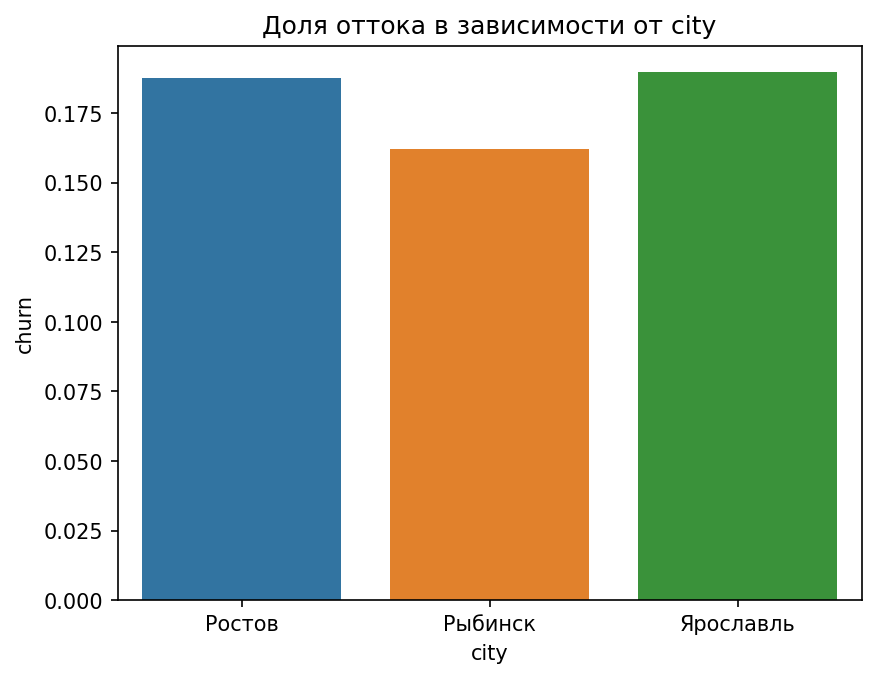

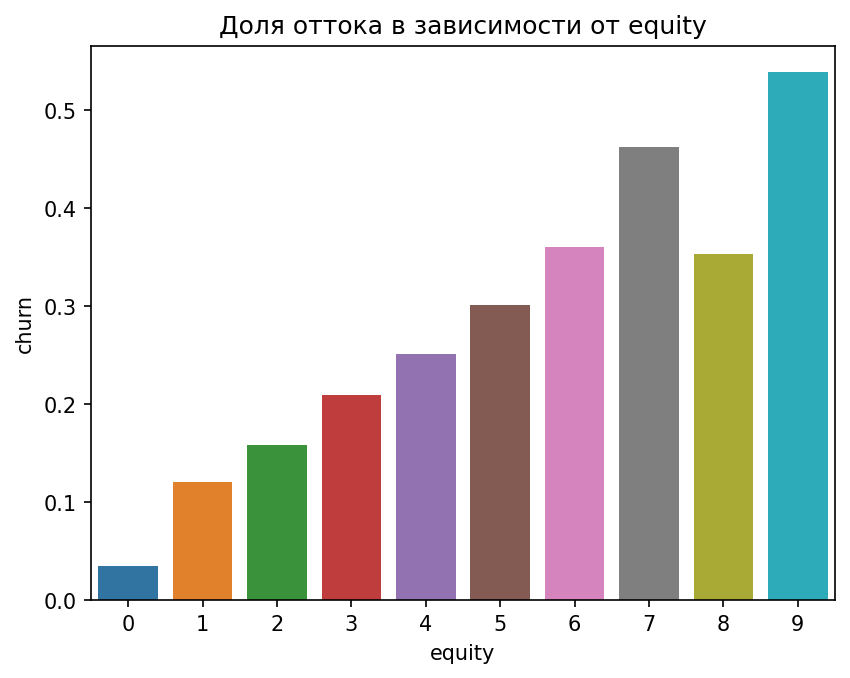

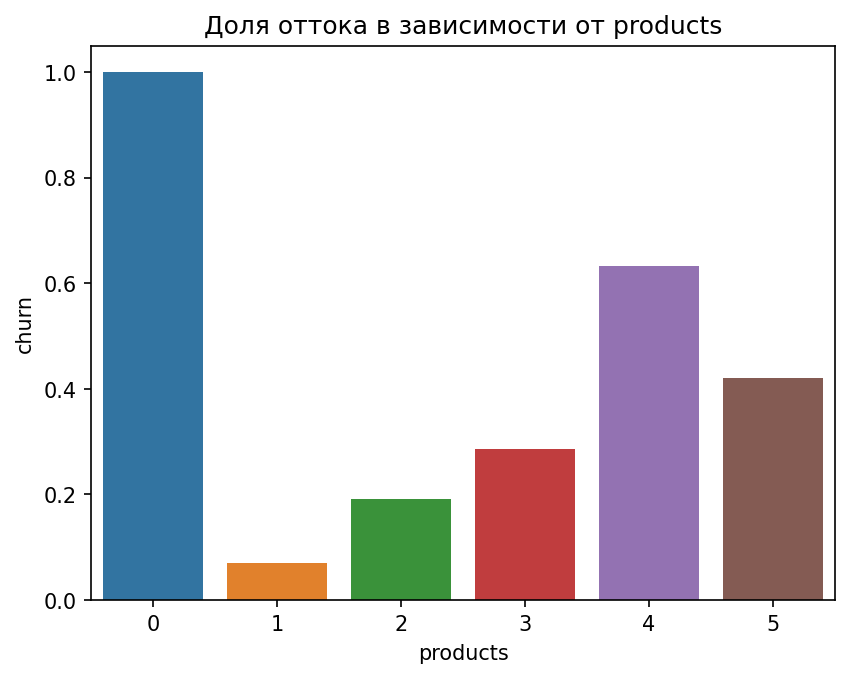

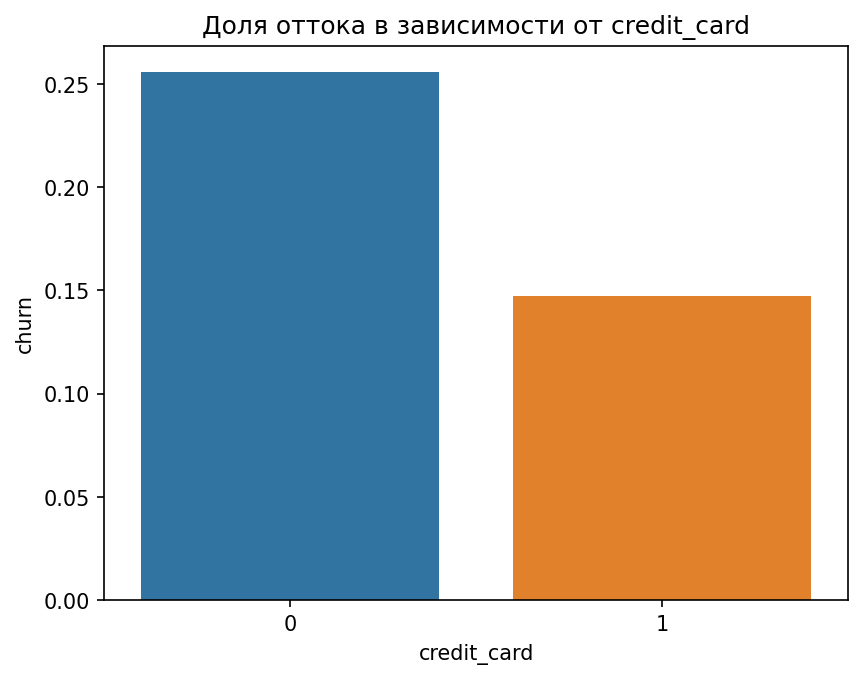

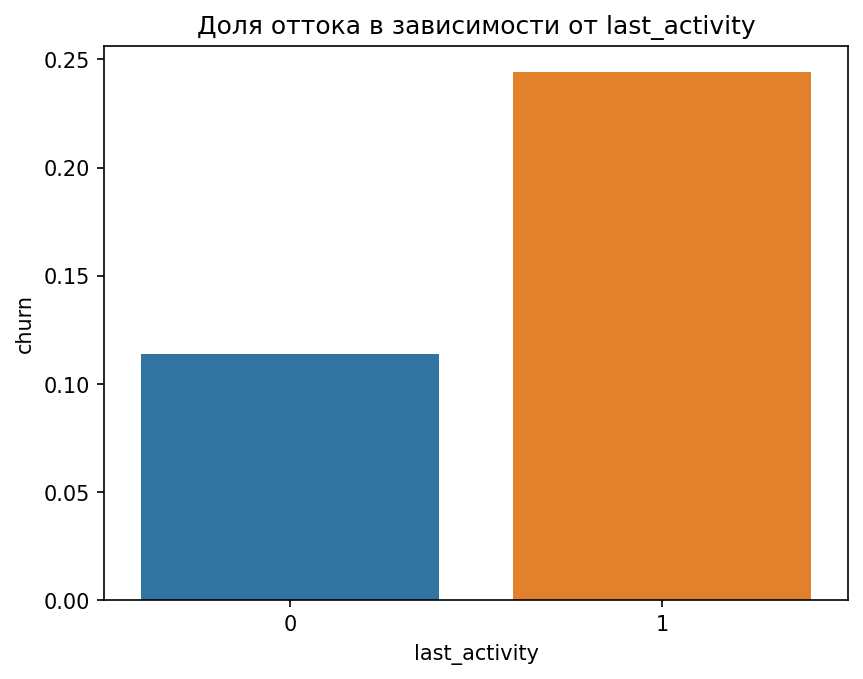

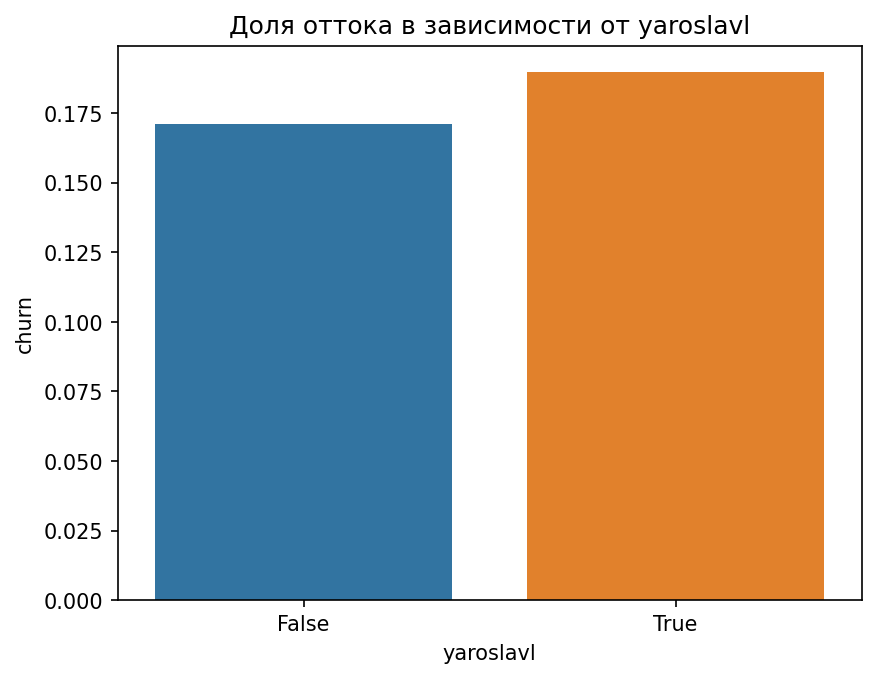

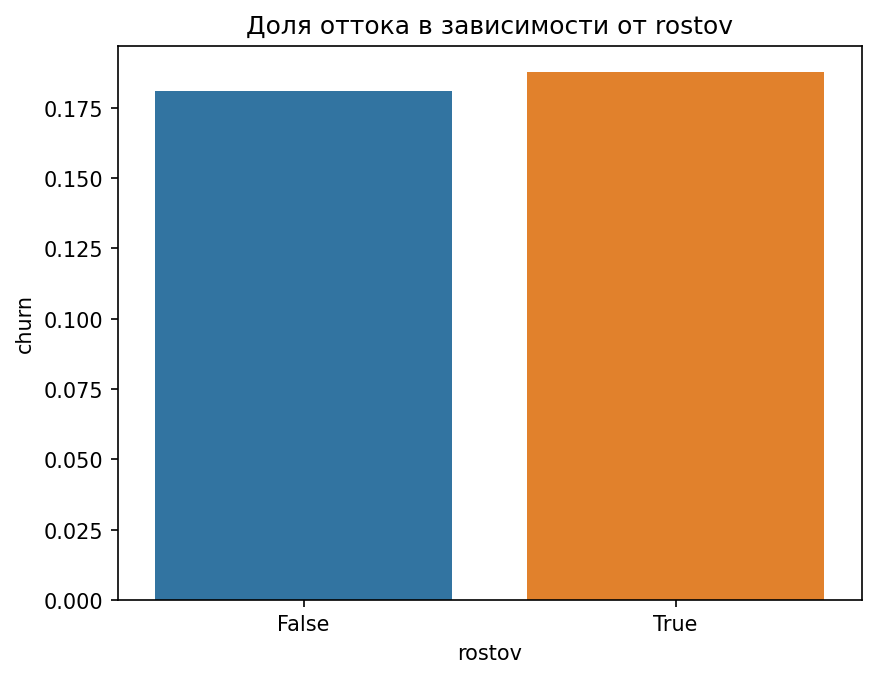

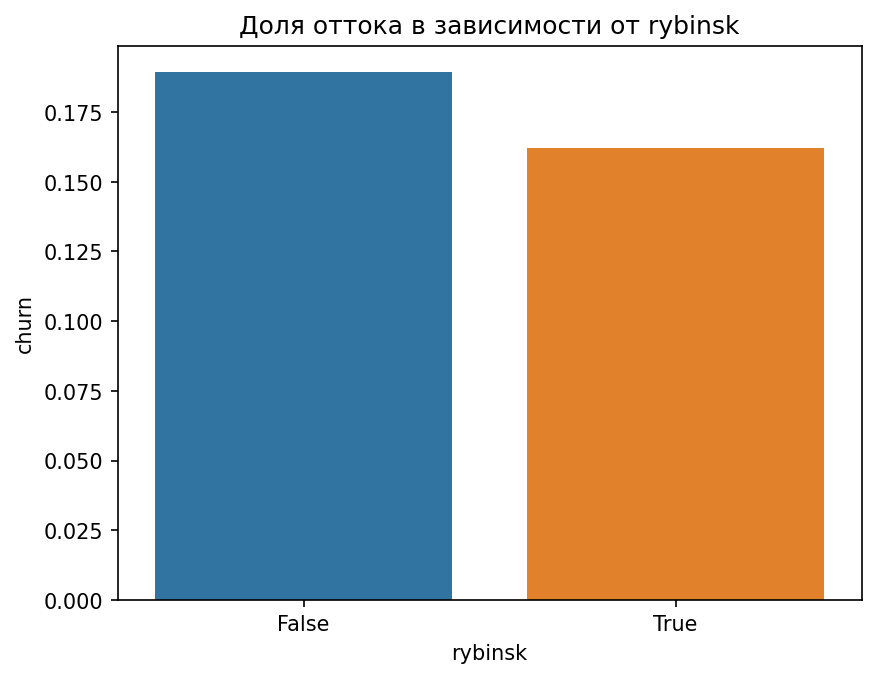

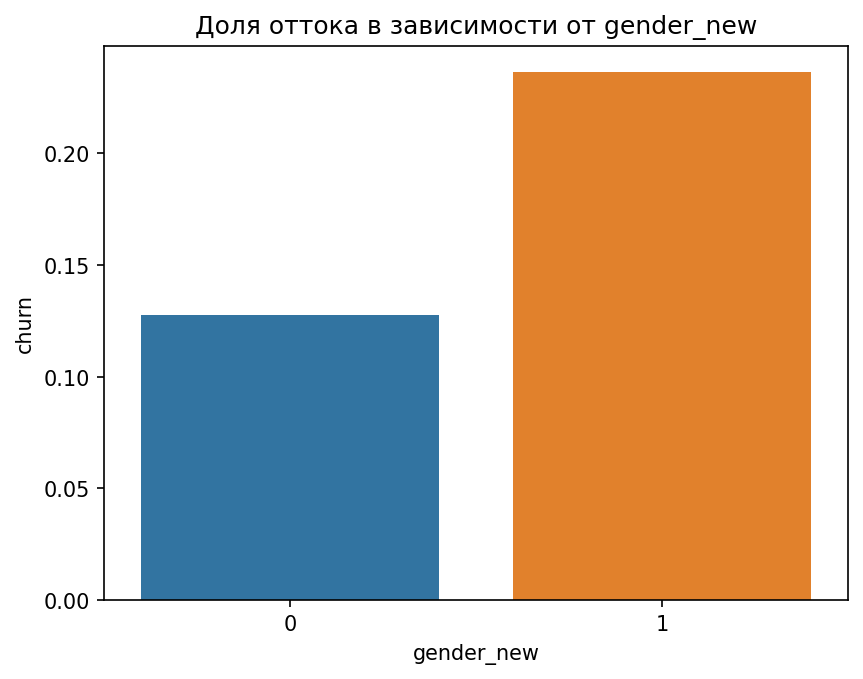

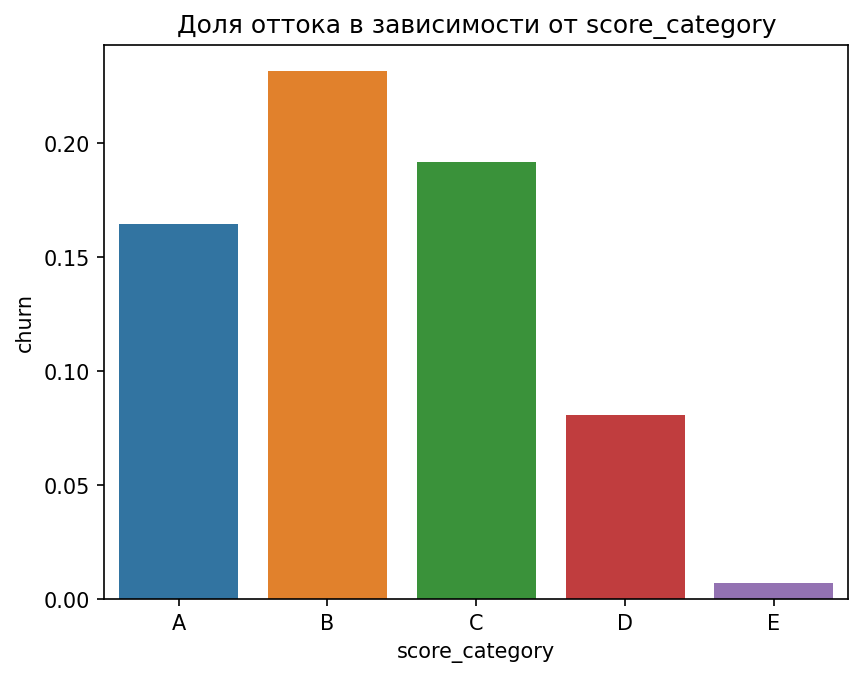

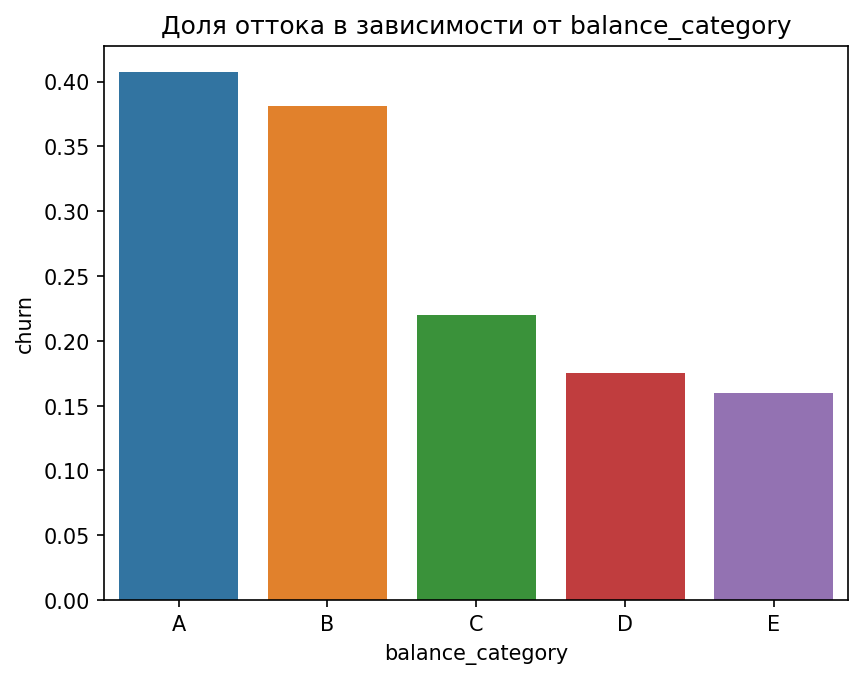

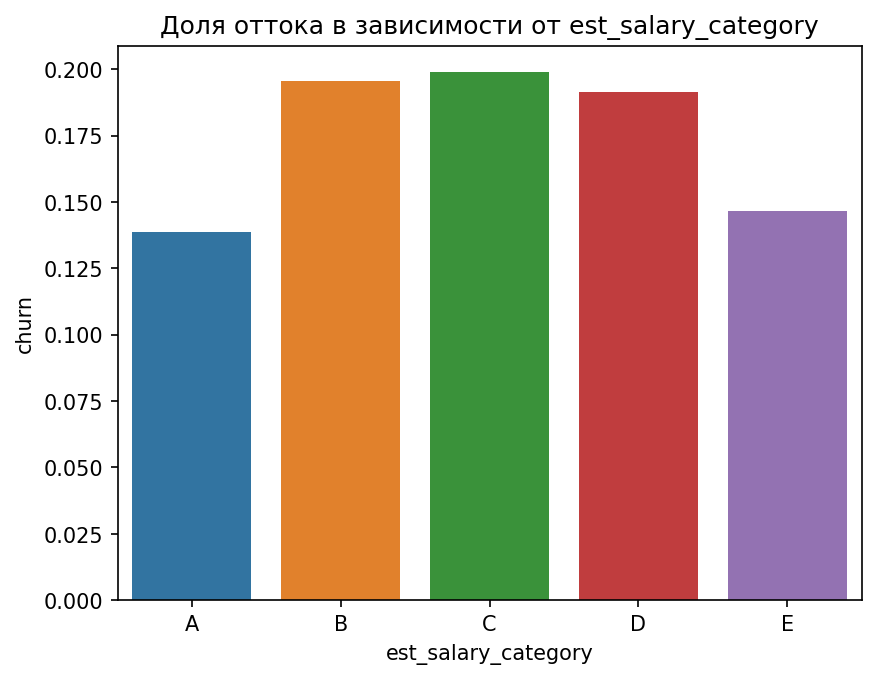

In [66]:
for column in list_of_columns:
    df_grouped = df.groupby(column, as_index=False, dropna=False)['churn'].mean()
    ax = sns.barplot(data=df_grouped, x=column, y='churn');
    plt.title(f'Доля оттока в зависимости от {column}')
    plt.show()

- При увеличении количества объектов в собственности и продуктов отток увеличивается
- Отток уменьшается с повышением параметра score и баланса на счете
- Доля отточных клиентов ниже для клиентов с кредитными картами
- Доля отточных клиентов выше для клиентов с недавней активностью активностью и для мужчин 

Отдельно построим распределение от возраста

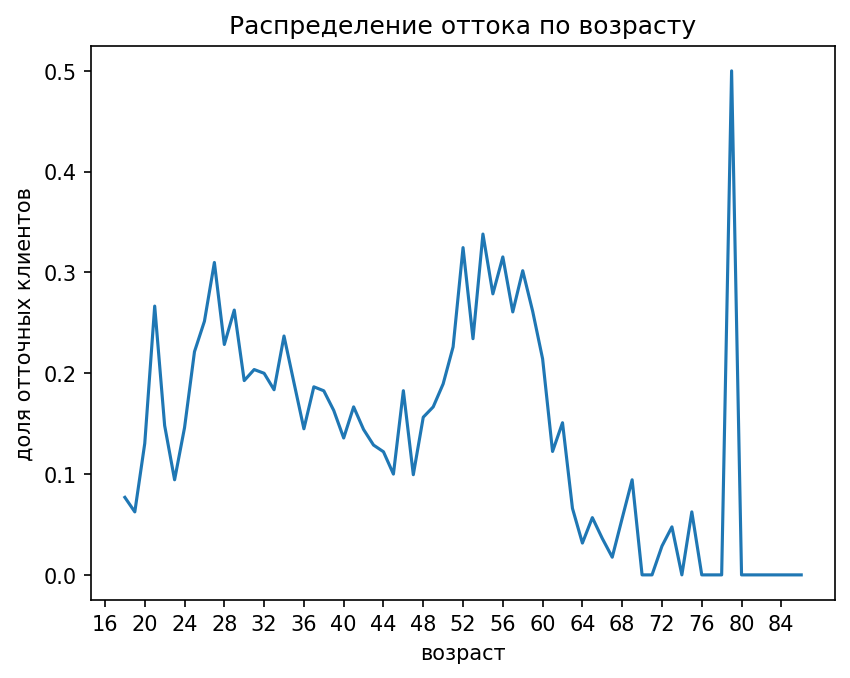

In [67]:
age = df.groupby('age', as_index=False)['churn'].mean()

ax=sns.lineplot(data=age, x='age', y='churn')

ax.set_title('Распределение оттока по возрасту')
ax.set(xlabel='возраст', ylabel='доля отточных клиентов')
plt.xticks(np.arange(16, 85, step=4))
plt.show()

наибольший отток в диапазонах 25-29 и 52-59 лет, пик на 79, видимо, связан со смертью клиента

### Сегментация пользователей на основе данных о количестве потребляемых продуктов

In [68]:
products = df.groupby('products').agg({'user_id':'count'}).reset_index()
products

products  user_id
0         0        1
1         1     3341
2         2     5126
3         3     1039
4         4      474
5         5       19

Пользователей без продуктов и с 5 продуктами можно не включать в анализ, так как их очень мало

In [69]:
products = df.query('0<products<5')
products = products.groupby('products').agg({'user_id':'count'}).assign(pct_total=(lambda x: x / x.sum()))
products = products.sort_values(by='pct_total', ascending = False).reset_index()
products

products  user_id  pct_total
0         2     5126   0.513627
1         1     3341   0.334770
2         3     1039   0.104108
3         4      474   0.047495

In [70]:
fig = go.Figure(data=[go.Pie(labels=products['products'], values=products['user_id'], pull = [0.1])])

fig.update_layout(title='Распределение клиентов по количеству продуктов',
                  width=600, height=600,
                  annotations=[dict(text='', showarrow=False)],
                  #xaxis_title='район',
                  #yaxis_title='количество заведений',
                  legend_title='количество продуктов')
                  #xaxis={'categoryarray':districts_list})
fig.show()

Теперь построим распределение по остальным признакам для всех значений количества продуктов

In [71]:
list_of_columns = ['city', 'equity', 'credit_card', 'last_activity', 'churn', 'gender_new',
       'score_category', 'balance_category', 'est_salary_category']

        city  user_id  pct_total
0     Ростов      444   0.132894
1    Рыбинск      865   0.258905
2  Ярославль     2032   0.608201


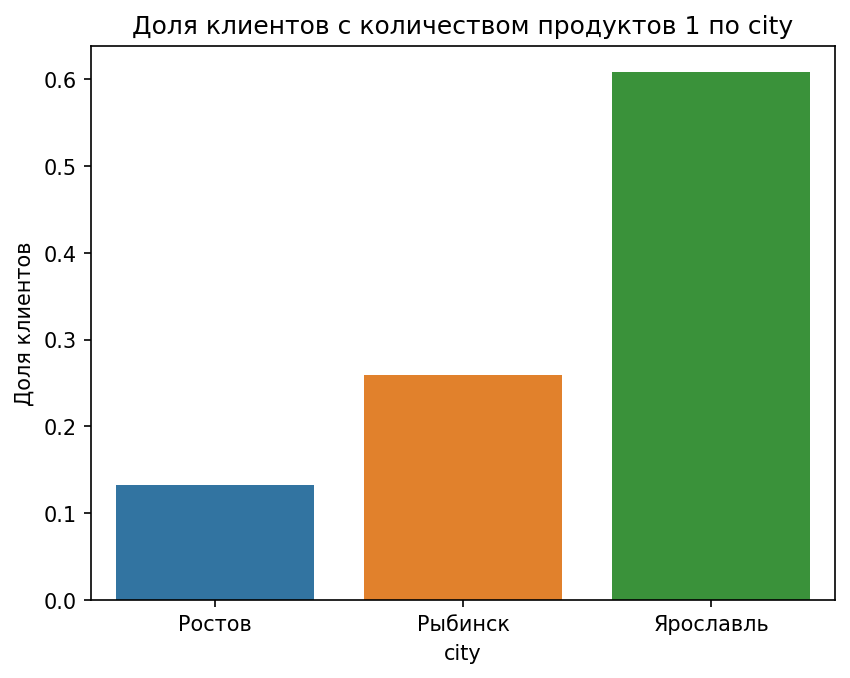

        city  user_id  pct_total
0     Ростов      806   0.157238
1    Рыбинск     1563   0.304916
2  Ярославль     2757   0.537846


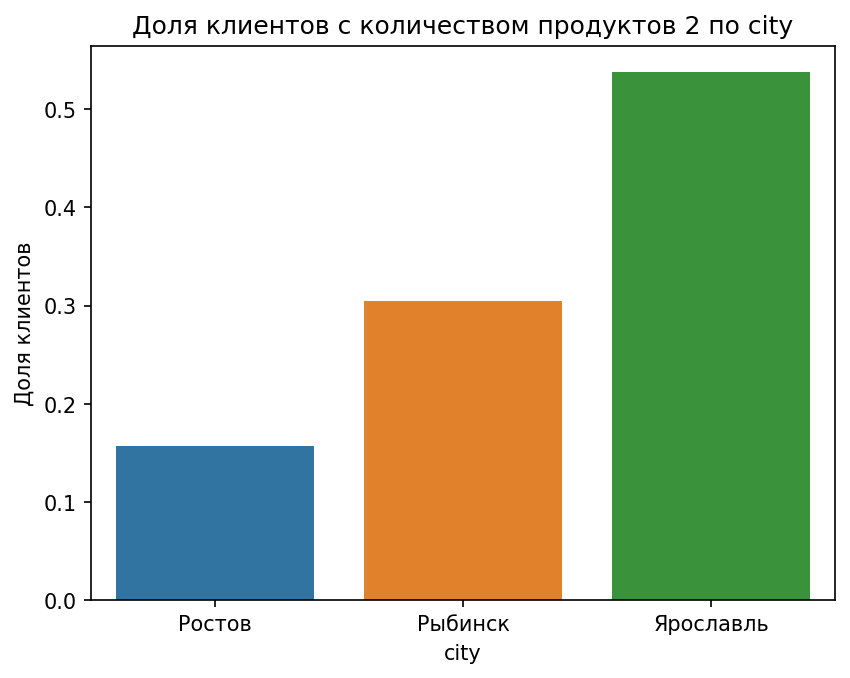

        city  user_id  pct_total
0     Ростов       95   0.091434
1    Рыбинск      166   0.159769
2  Ярославль      778   0.748797


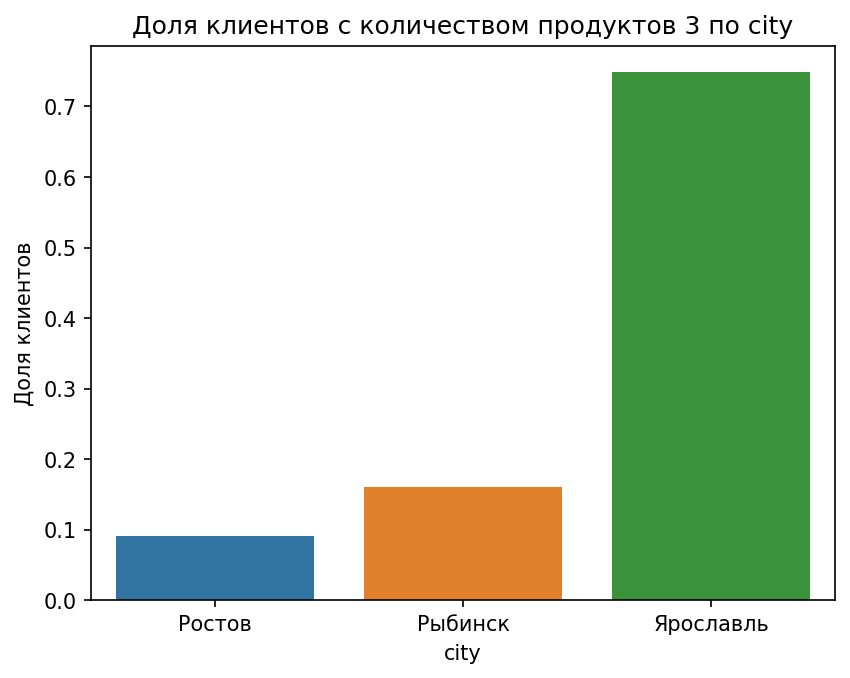

        city  user_id  pct_total
0     Ростов       68   0.143460
1    Рыбинск       99   0.208861
2  Ярославль      307   0.647679


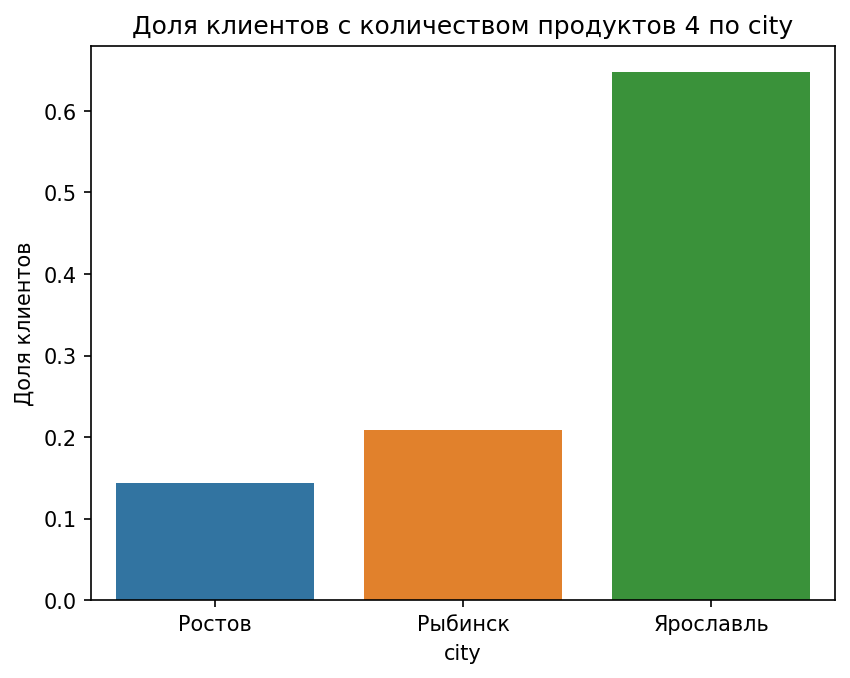

   equity  user_id  pct_total
0       0     1975   0.591140
1       1      255   0.076324
2       2      192   0.057468
3       3      288   0.086202
4       4      301   0.090093
5       5      284   0.085004
6       6       27   0.008081
7       7       16   0.004789
8       8        2   0.000599
9       9        1   0.000299


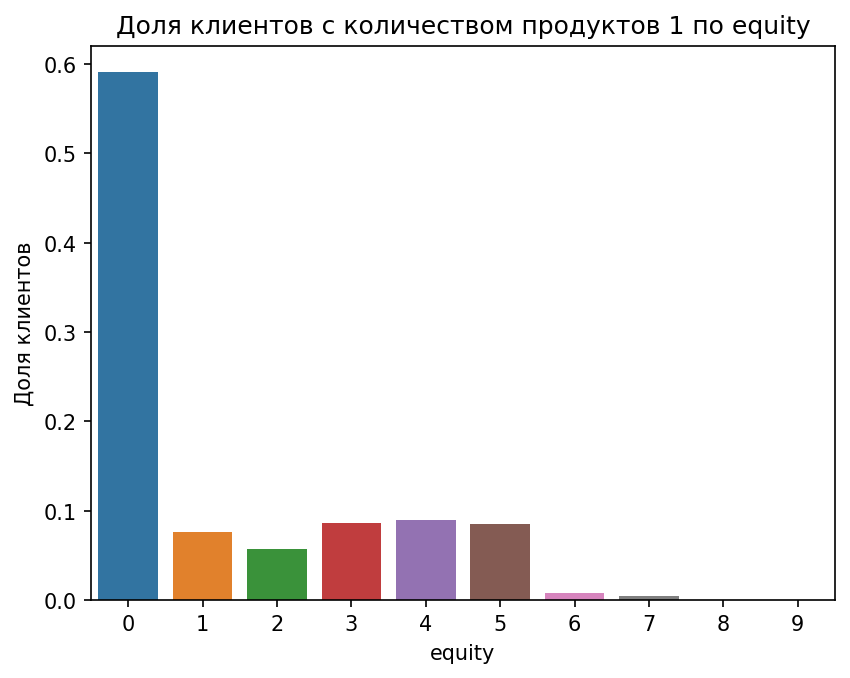

   equity  user_id  pct_total
0       0      547   0.106711
1       1      433   0.084471
2       2      709   0.138314
3       3      982   0.191572
4       4     1140   0.222396
5       5     1178   0.229809
6       6       80   0.015607
7       7       38   0.007413
8       8       11   0.002146
9       9        8   0.001561


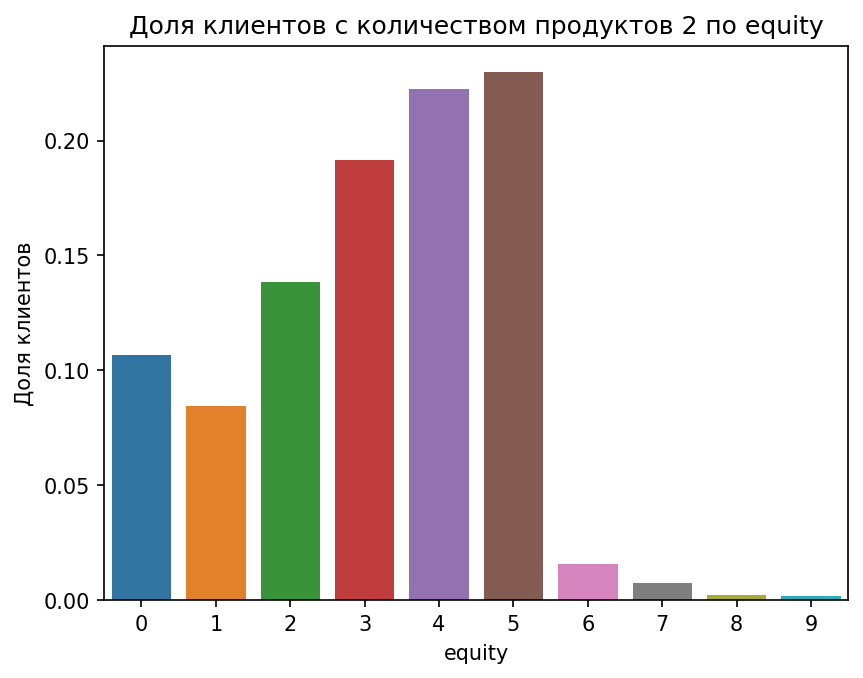

   equity  user_id  pct_total
0       0       58   0.055823
1       1       71   0.068335
2       2      117   0.112608
3       3      199   0.191530
4       4      275   0.264678
5       5      280   0.269490
6       6       25   0.024062
7       7       10   0.009625
8       8        2   0.001925
9       9        2   0.001925


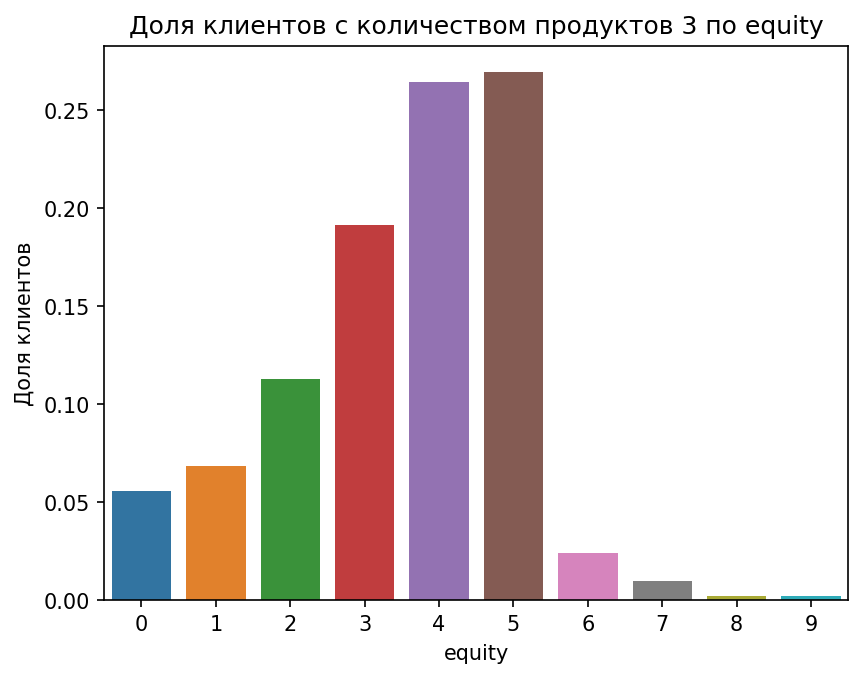

   equity  user_id  pct_total
0       0       12   0.025316
1       1       13   0.027426
2       2       32   0.067511
3       3       70   0.147679
4       4      129   0.272152
5       5      169   0.356540
6       6       29   0.061181
7       7       16   0.033755
8       8        2   0.004219
9       9        2   0.004219


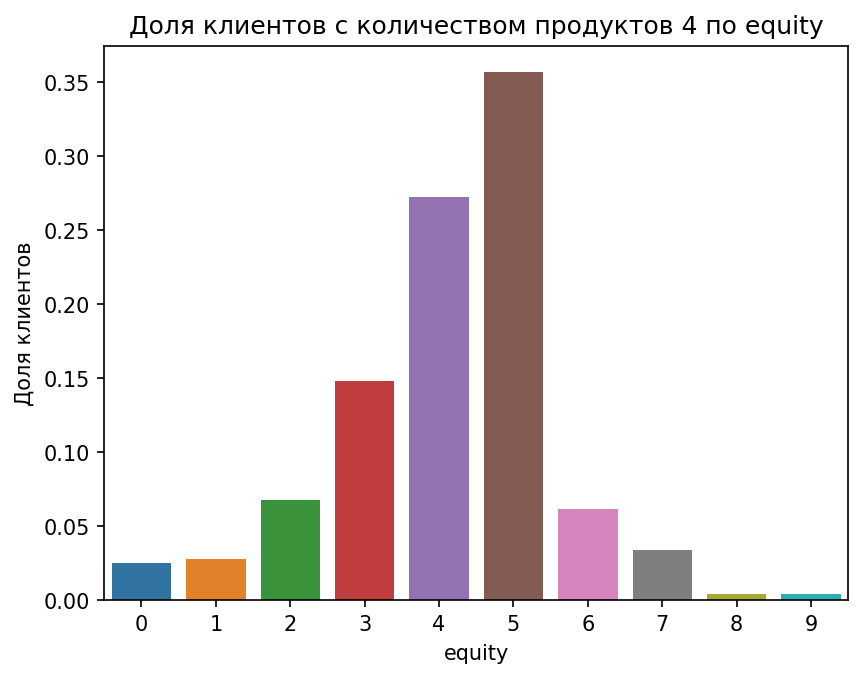

   credit_card  user_id  pct_total
0            0      455   0.136187
1            1     2886   0.863813


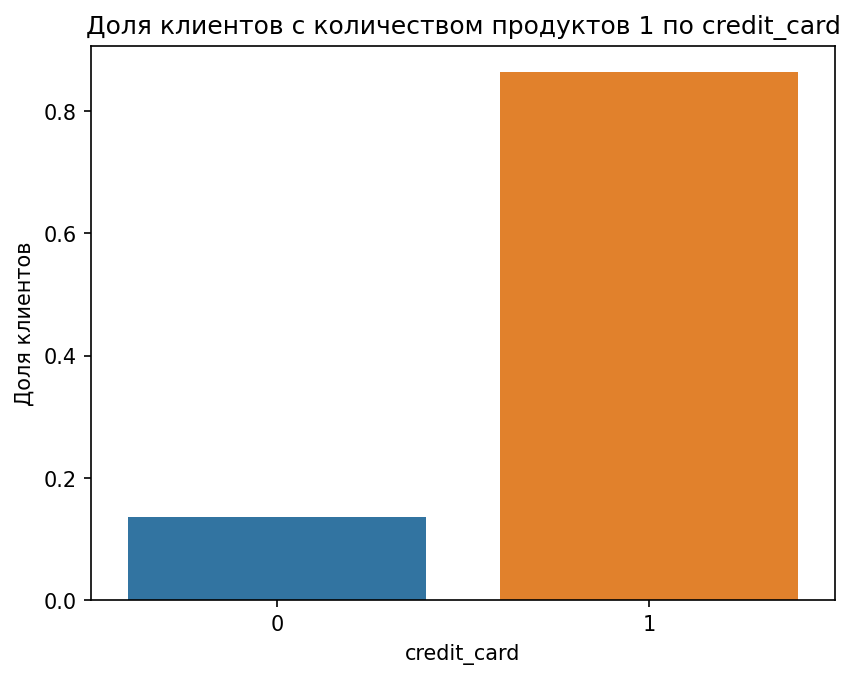

   credit_card  user_id  pct_total
0            0     1920   0.374561
1            1     3206   0.625439


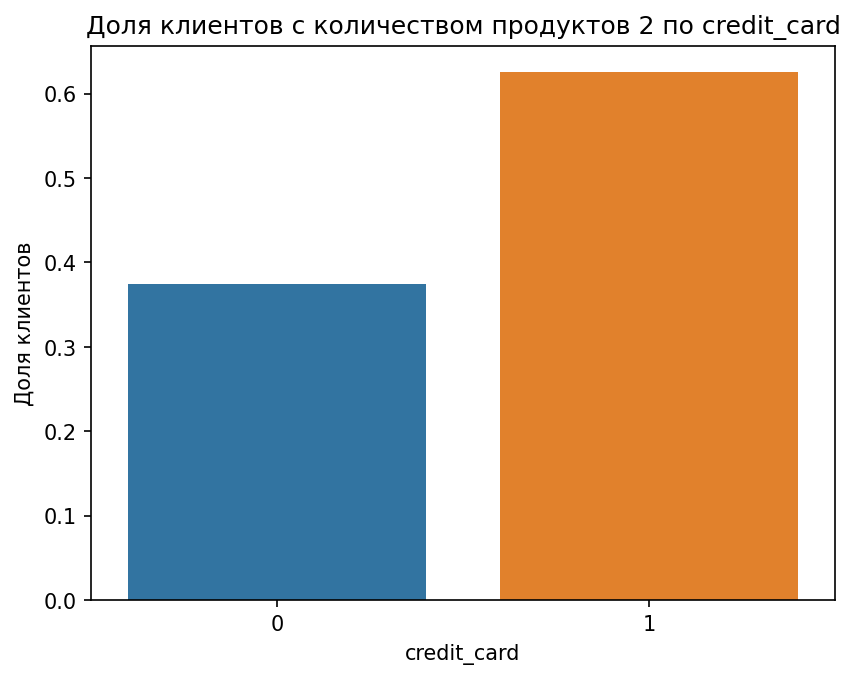

   credit_card  user_id  pct_total
0            0      669   0.643888
1            1      370   0.356112


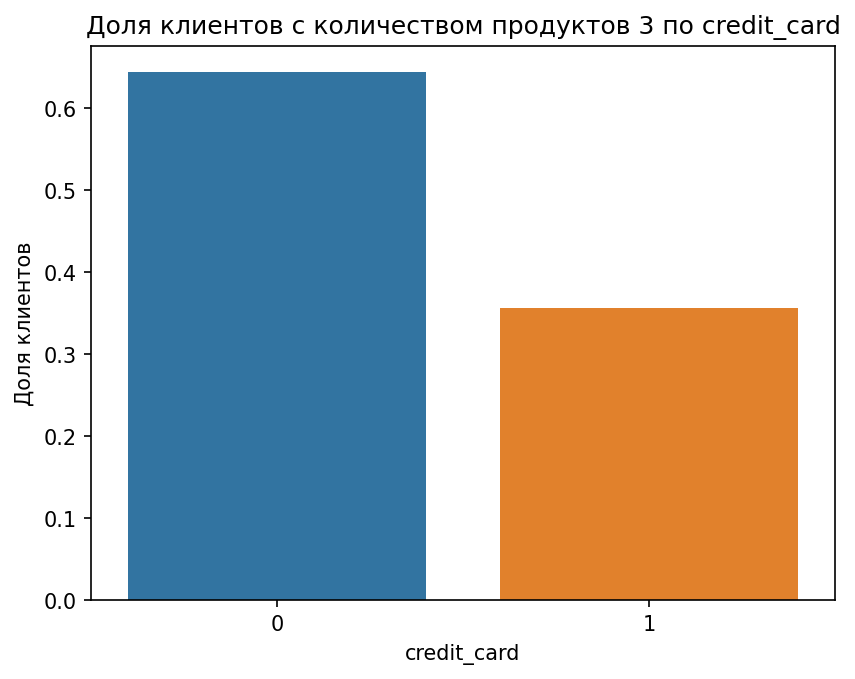

   credit_card  user_id  pct_total
0            0      151   0.318565
1            1      323   0.681435


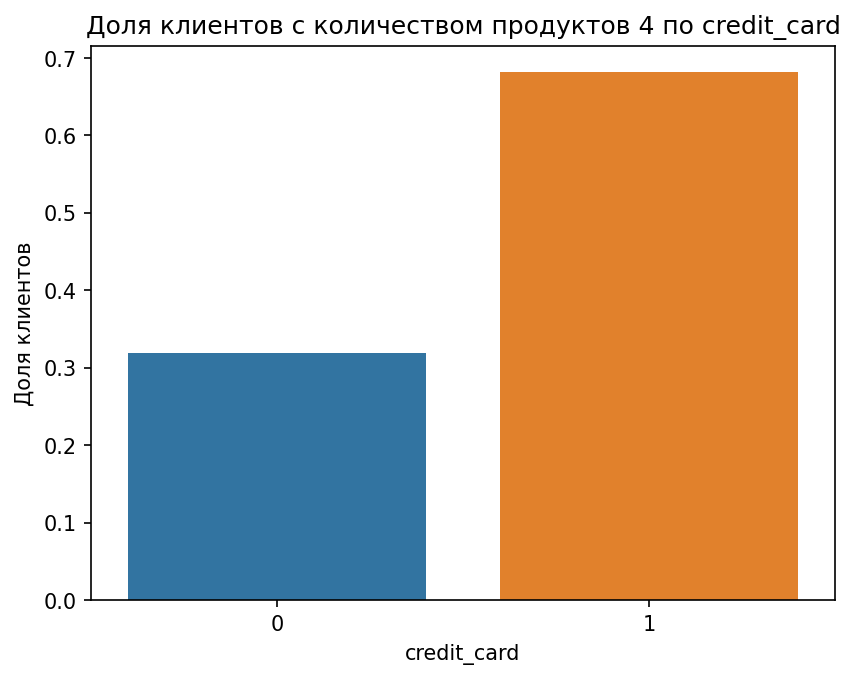

   last_activity  user_id  pct_total
0              0     1576   0.471715
1              1     1765   0.528285


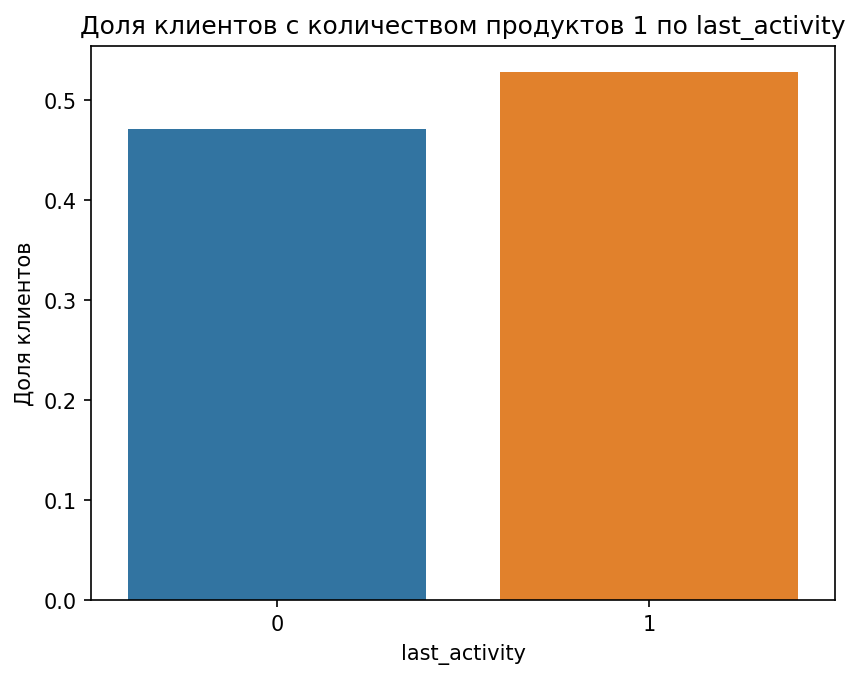

   last_activity  user_id  pct_total
0              0     2480   0.483808
1              1     2646   0.516192


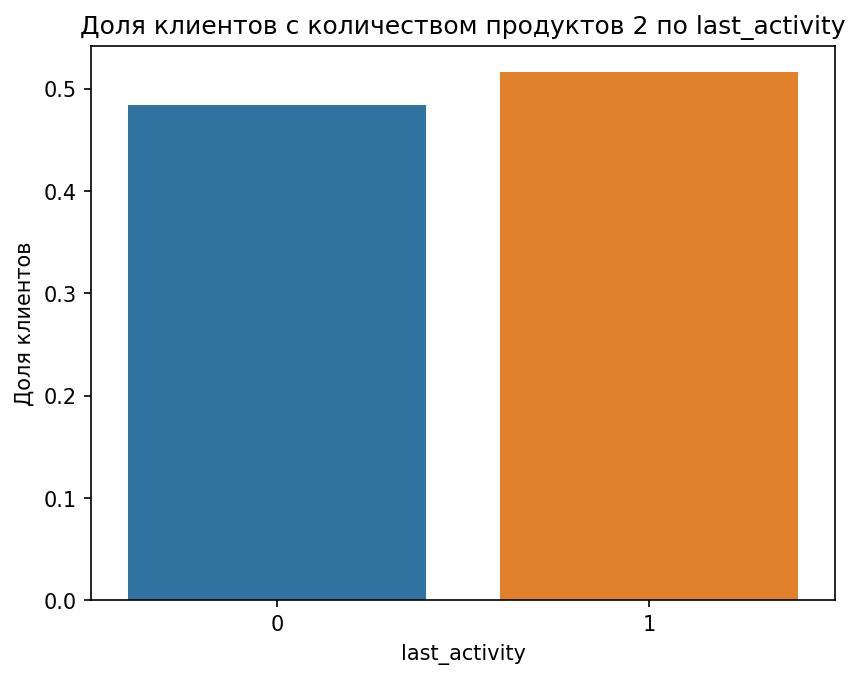

   last_activity  user_id  pct_total
0              0      606   0.583253
1              1      433   0.416747


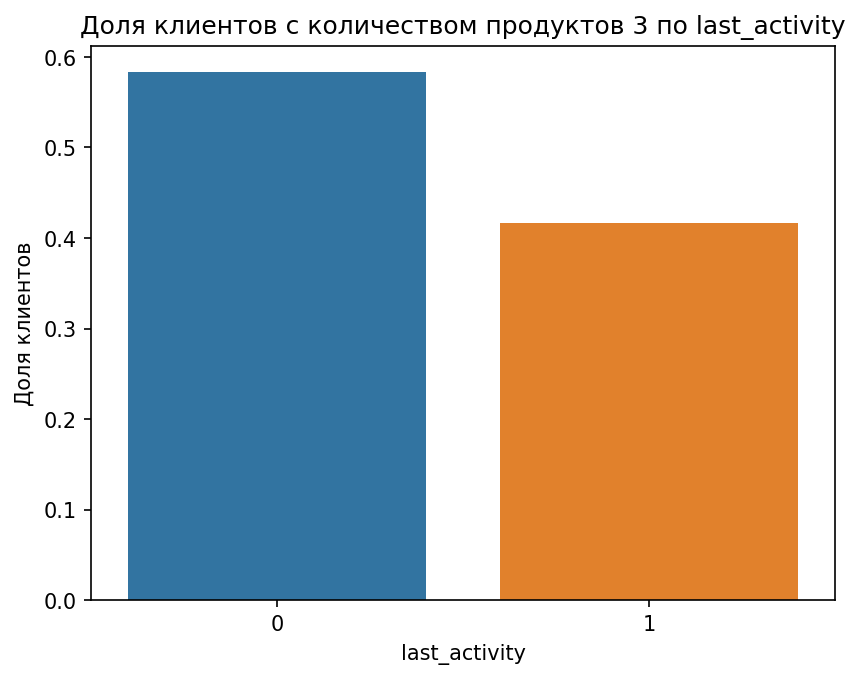

   last_activity  user_id  pct_total
0              0      100    0.21097
1              1      374    0.78903


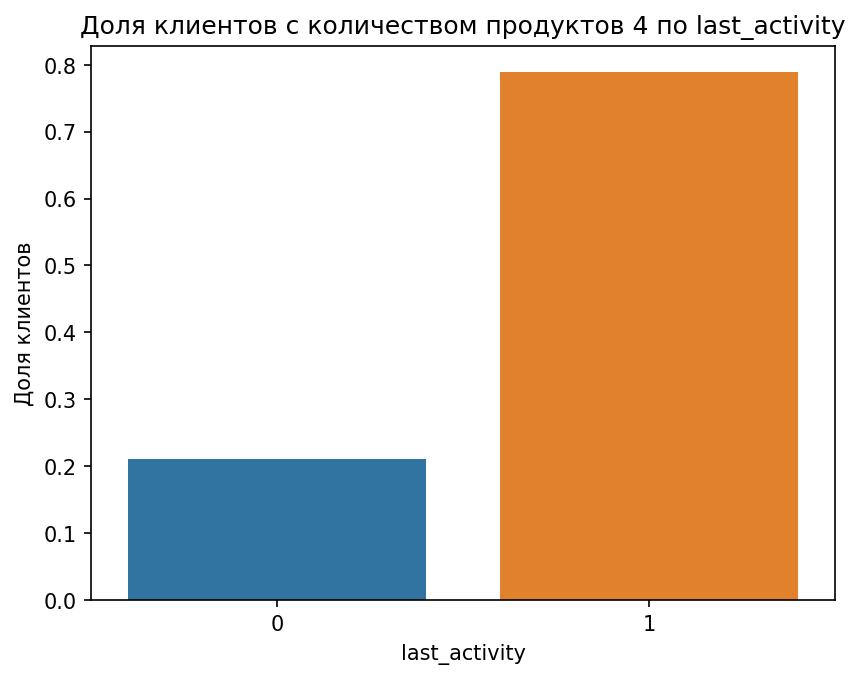

   churn  user_id  pct_total
0      0     3106   0.929662
1      1      235   0.070338


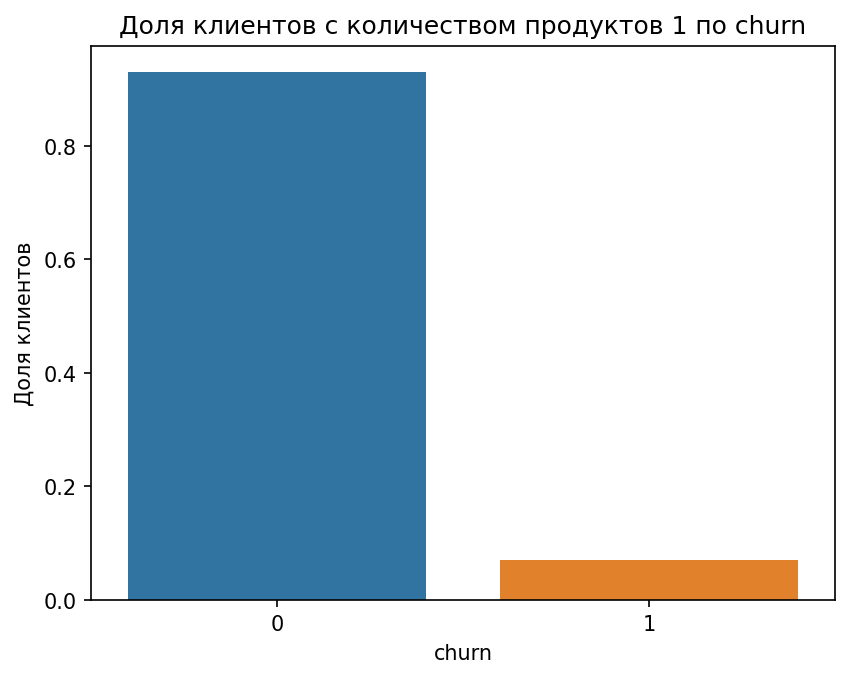

   churn  user_id  pct_total
0      0     4147   0.809013
1      1      979   0.190987


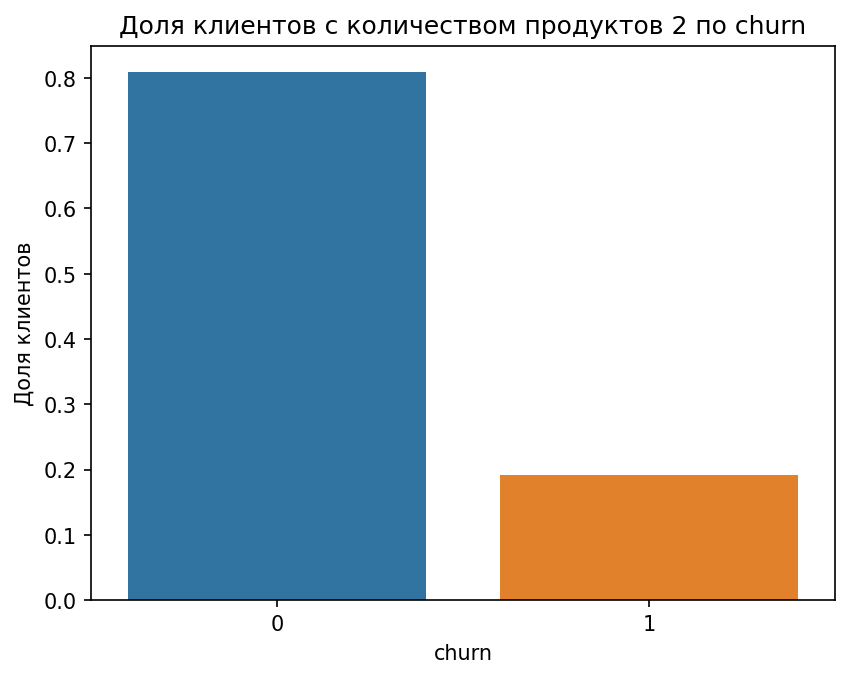

   churn  user_id  pct_total
0      0      742   0.714148
1      1      297   0.285852


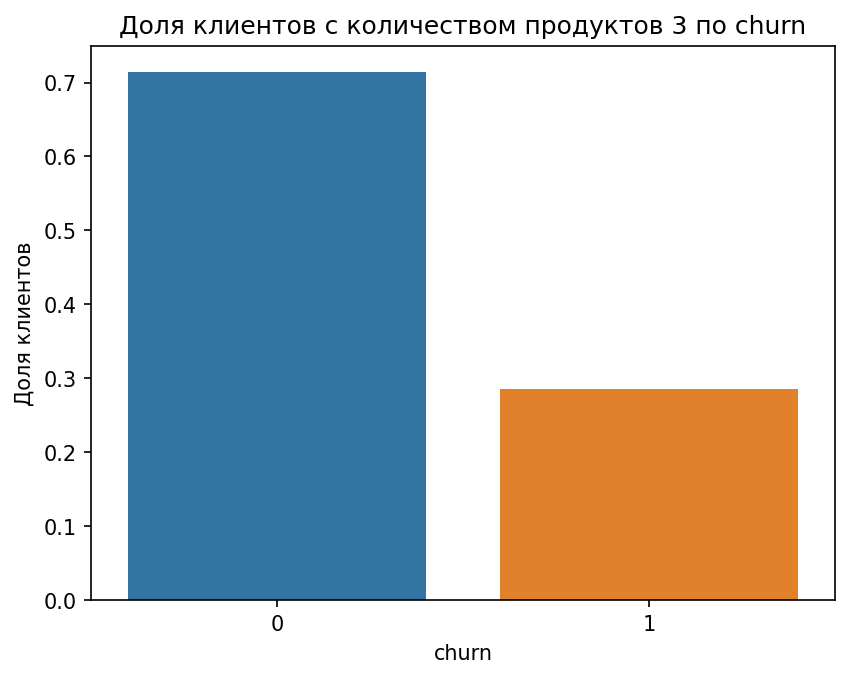

   churn  user_id  pct_total
0      0      174   0.367089
1      1      300   0.632911


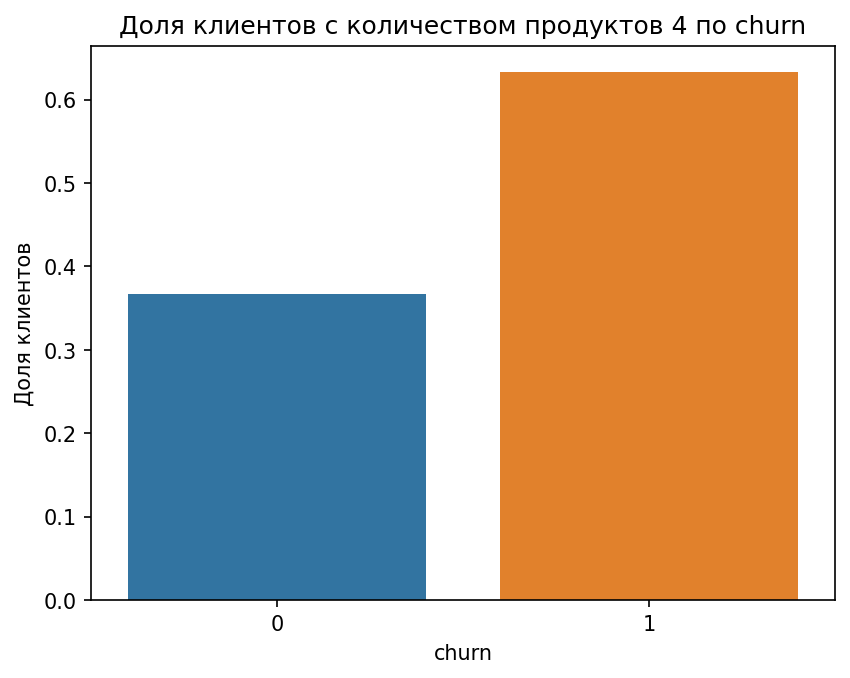

   gender_new  user_id  pct_total
0           0     1534   0.459144
1           1     1807   0.540856


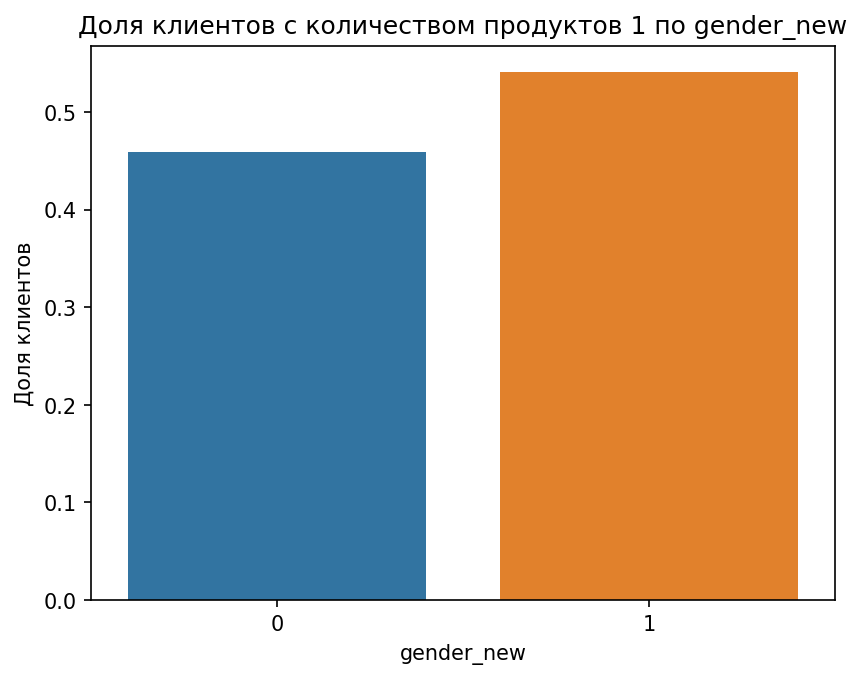

   gender_new  user_id  pct_total
0           0     2680   0.522825
1           1     2446   0.477175


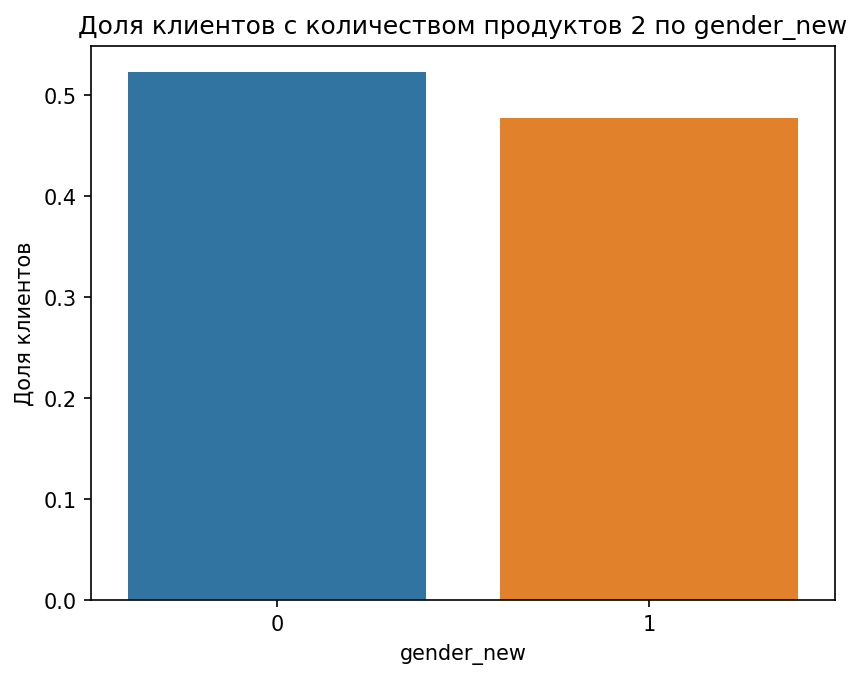

   gender_new  user_id  pct_total
0           0      592   0.569779
1           1      447   0.430221


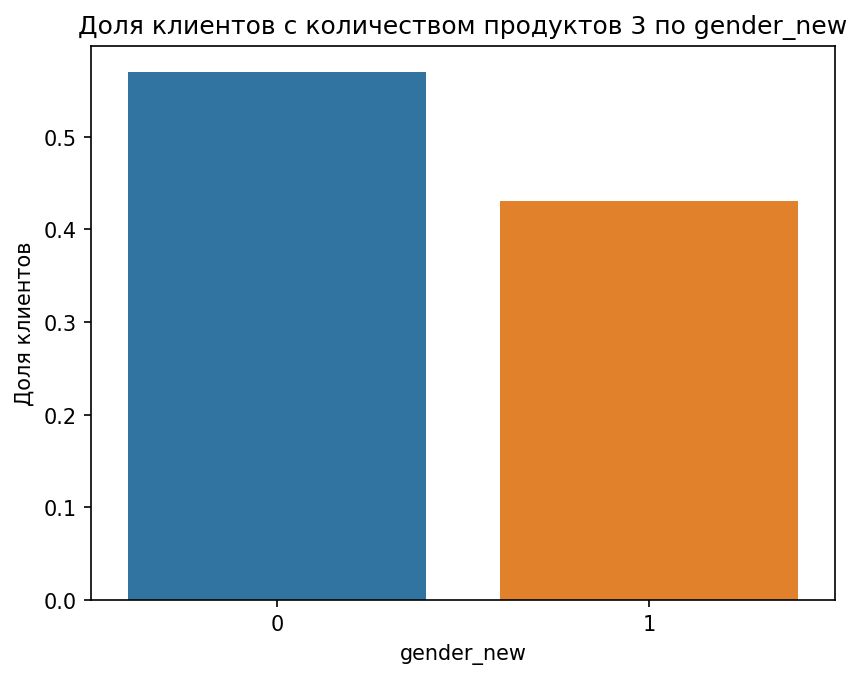

   gender_new  user_id  pct_total
0           0      179   0.377637
1           1      295   0.622363


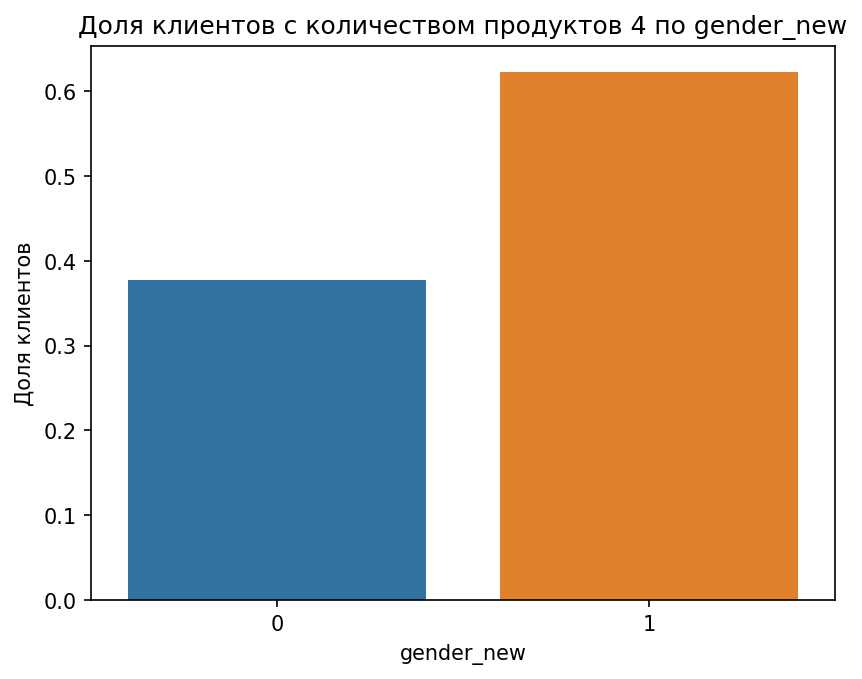

  score_category  user_id  pct_total
0              A      467   0.139779
1              B     1475   0.441485
2              C      680   0.203532
3              D      491   0.146962
4              E      228   0.068243


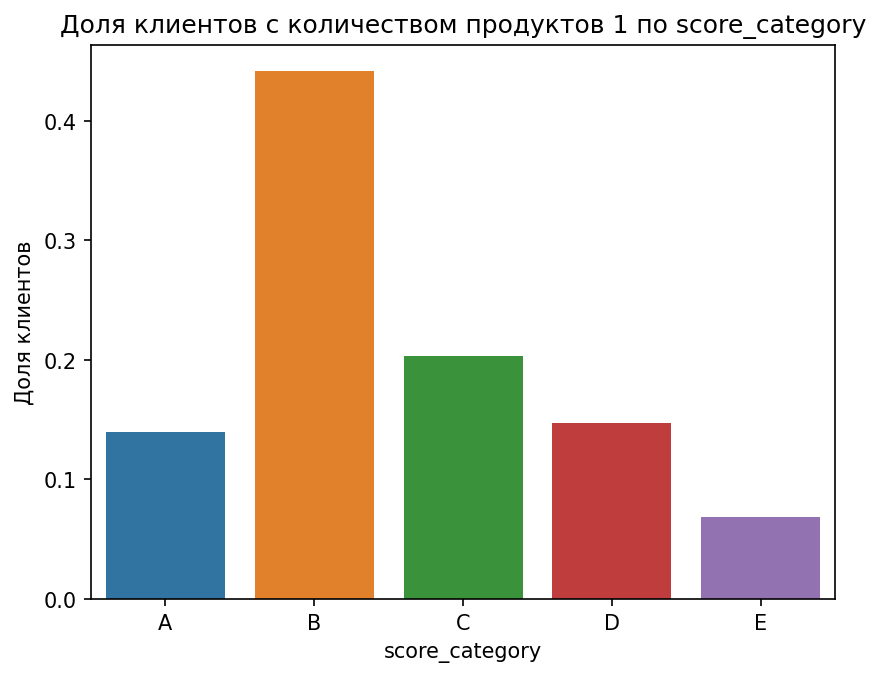

  score_category  user_id  pct_total
0              A      367   0.071596
1              B     1779   0.347054
2              C     2114   0.412407
3              D      819   0.159774
4              E       47   0.009169


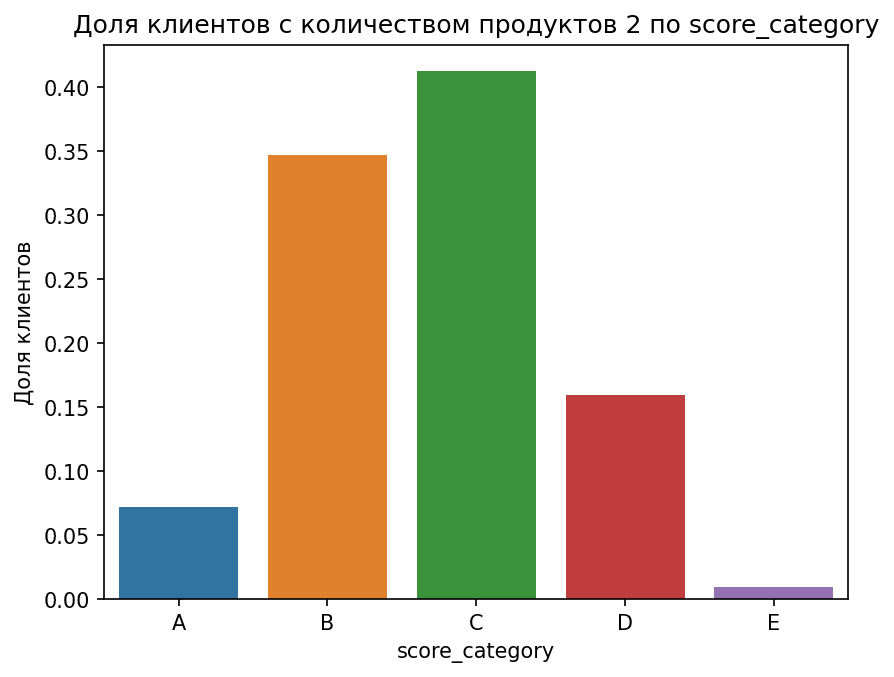

  score_category  user_id  pct_total
0              A       75   0.072185
1              B      278   0.267565
2              C      474   0.456208
3              D      208   0.200192
4              E        4   0.003850


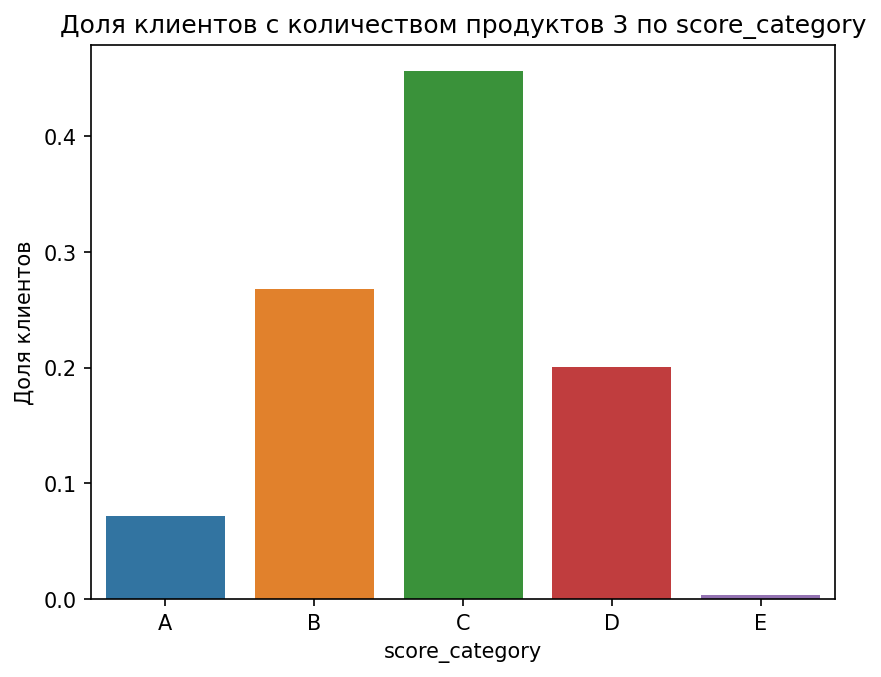

  score_category  user_id  pct_total
0              A       62   0.130802
1              B      252   0.531646
2              C      155   0.327004
3              D        5   0.010549


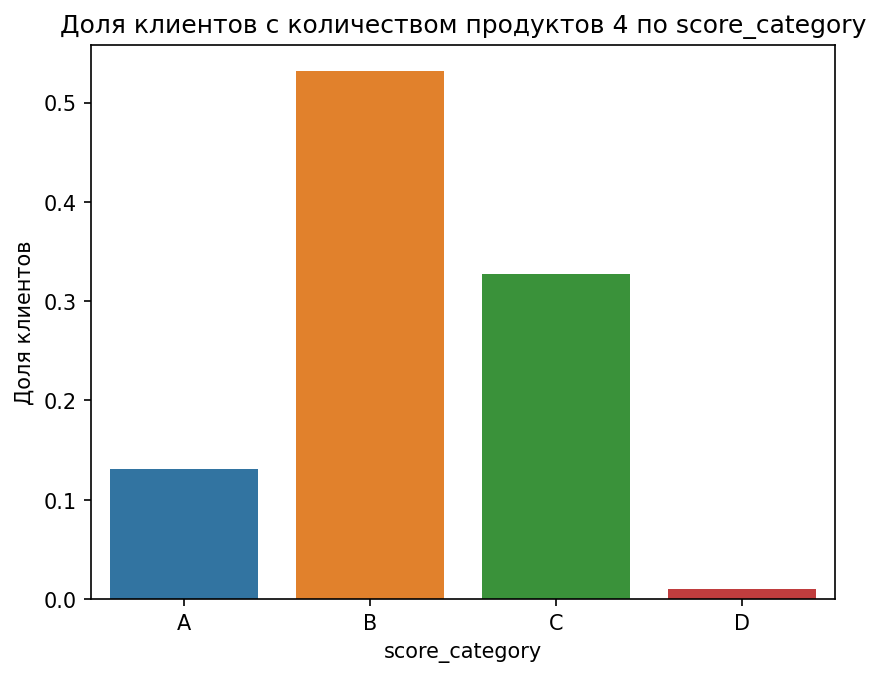

  balance_category  user_id  pct_total
0                A        4   0.002876
1                B      208   0.149533
2                C      323   0.232207
3                D      379   0.272466
4                E      477   0.342919


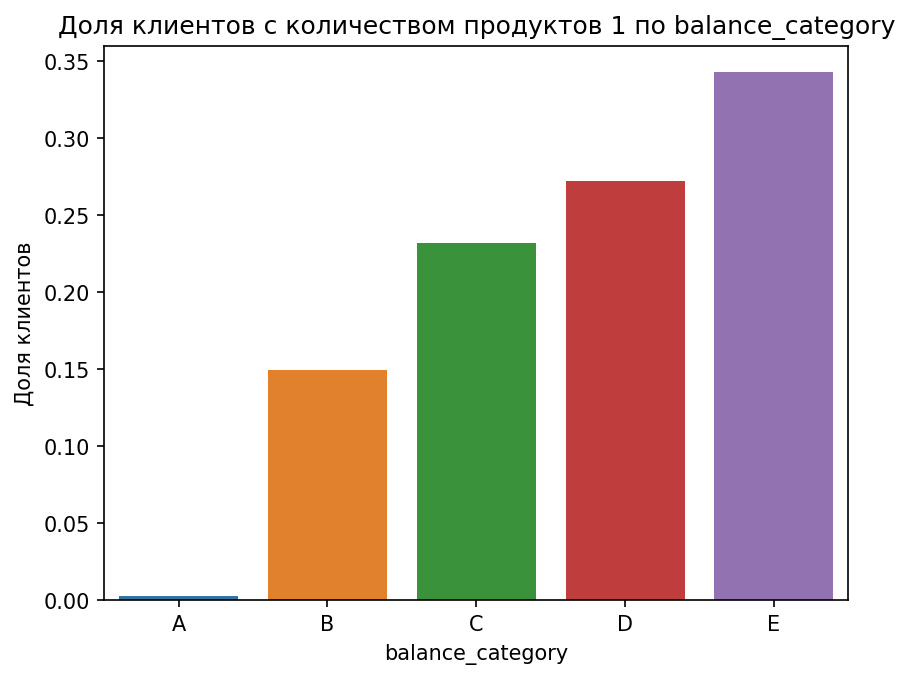

  balance_category  user_id  pct_total
0                A       19   0.003949
1                B     1106   0.229890
2                C     1258   0.261484
3                D     1230   0.255664
4                E     1198   0.249013


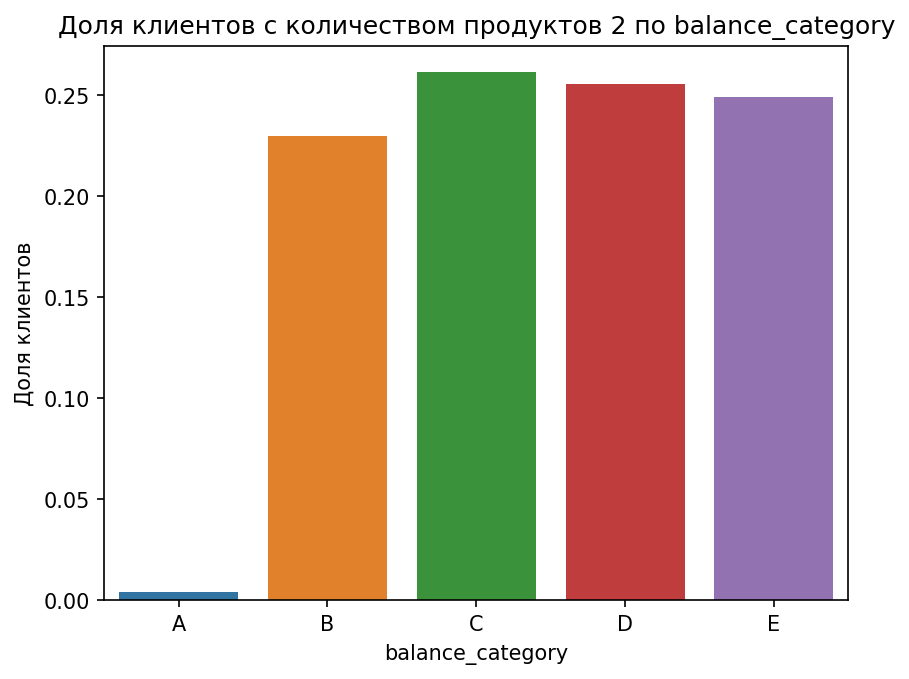

  balance_category  user_id  pct_total
0                A        2   0.001980
1                B      368   0.364356
2                C      238   0.235644
3                D      228   0.225743
4                E      174   0.172277


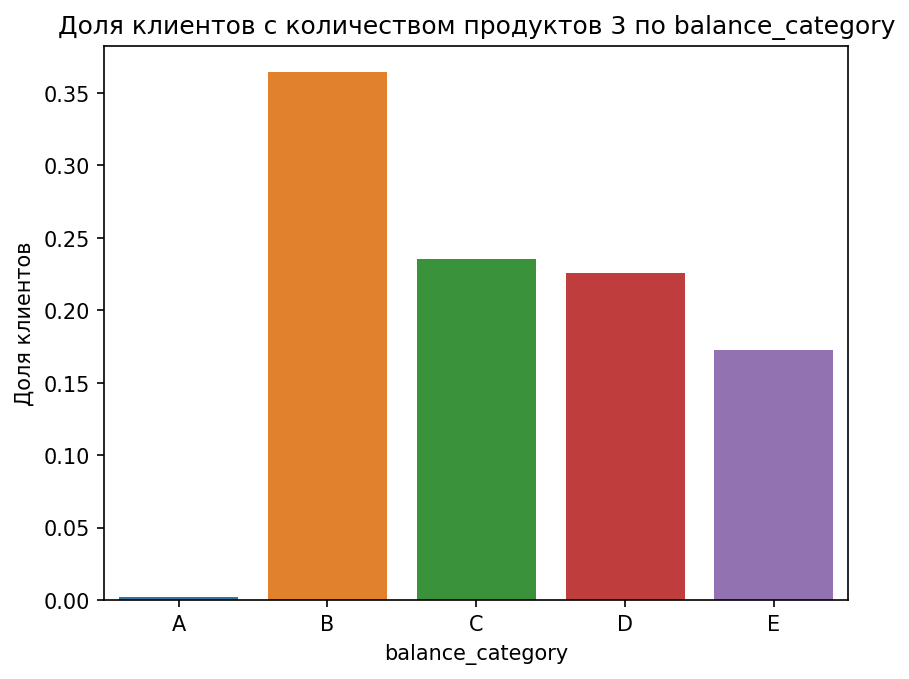

  balance_category  user_id  pct_total
0                A        2   0.004219
1                B      231   0.487342
2                C       99   0.208861
3                D       82   0.172996
4                E       60   0.126582


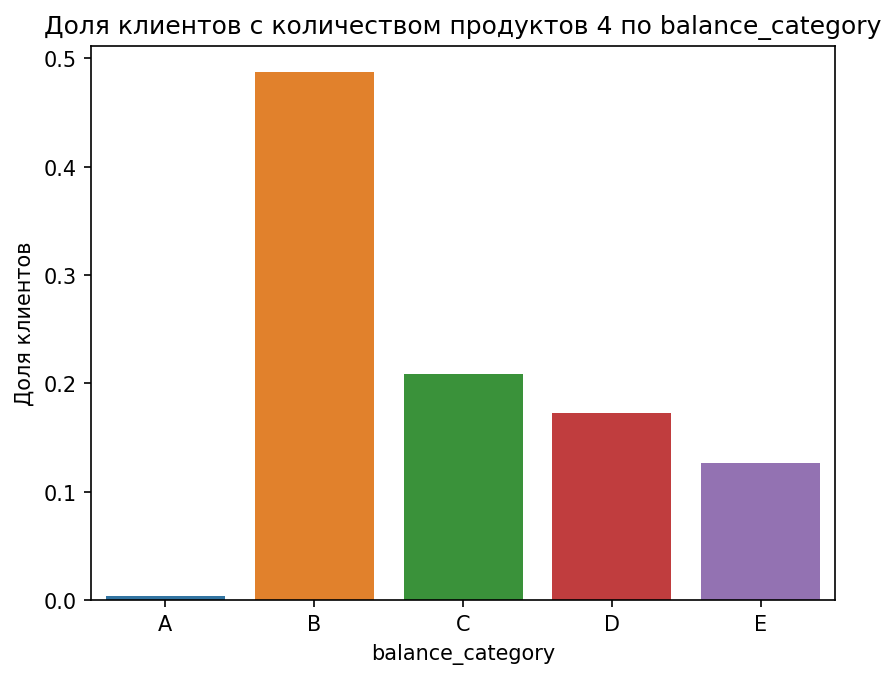

  est_salary_category  user_id  pct_total
0                   A      157   0.046992
1                   B     1104   0.330440
2                   C      832   0.249027
3                   D      674   0.201736
4                   E      574   0.171805


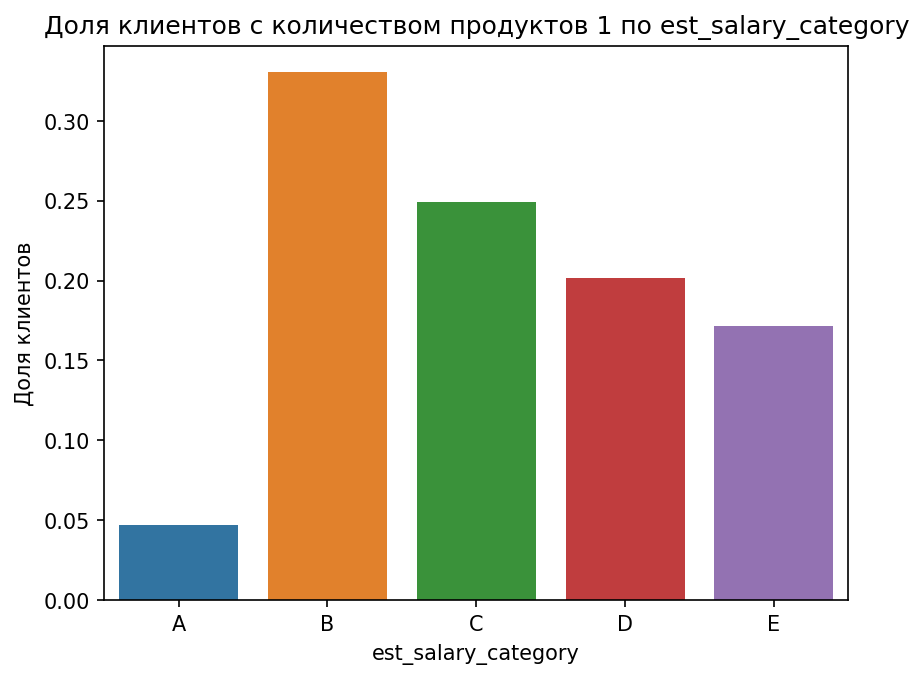

  est_salary_category  user_id  pct_total
0                   A       86   0.016777
1                   B      995   0.194108
2                   C     1248   0.243465
3                   D     1371   0.267460
4                   E     1426   0.278190


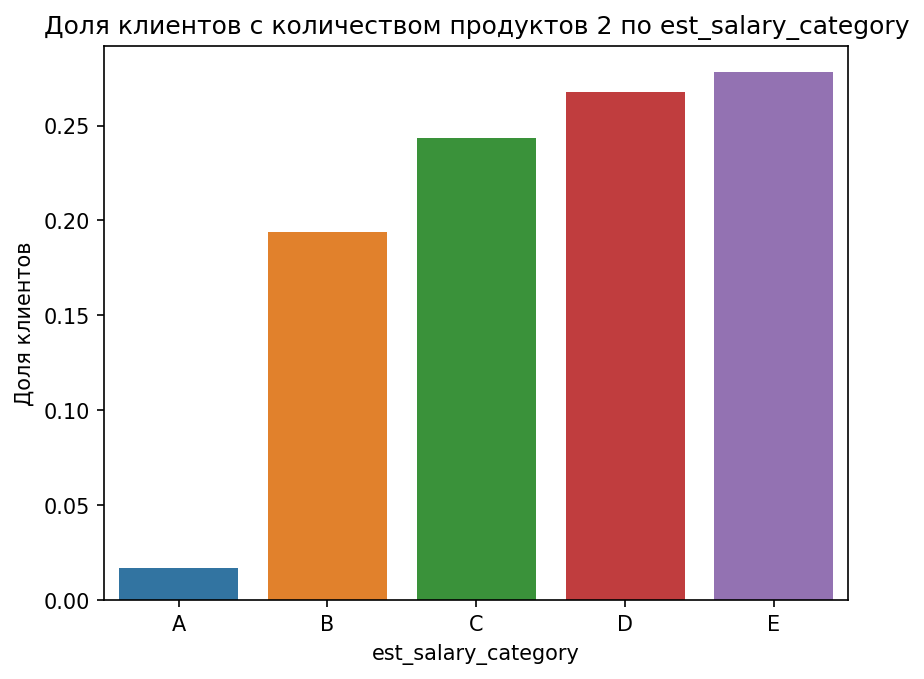

  est_salary_category  user_id  pct_total
0                   A       14   0.013474
1                   B      205   0.197305
2                   C      233   0.224254
3                   D      276   0.265640
4                   E      311   0.299326


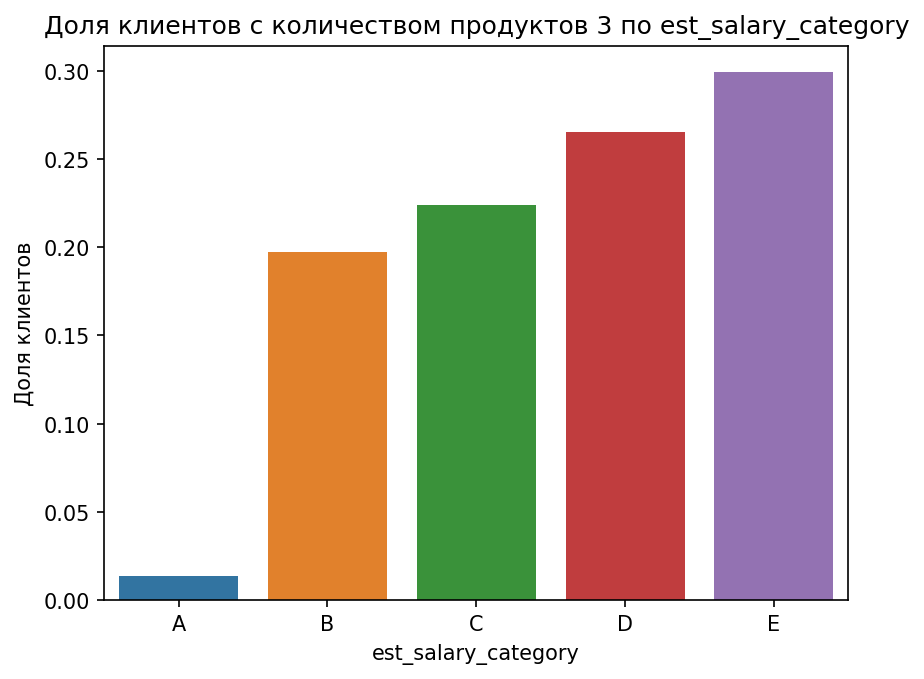

  est_salary_category  user_id  pct_total
0                   A       10   0.021097
1                   B      128   0.270042
2                   C      113   0.238397
3                   D      105   0.221519
4                   E      118   0.248945


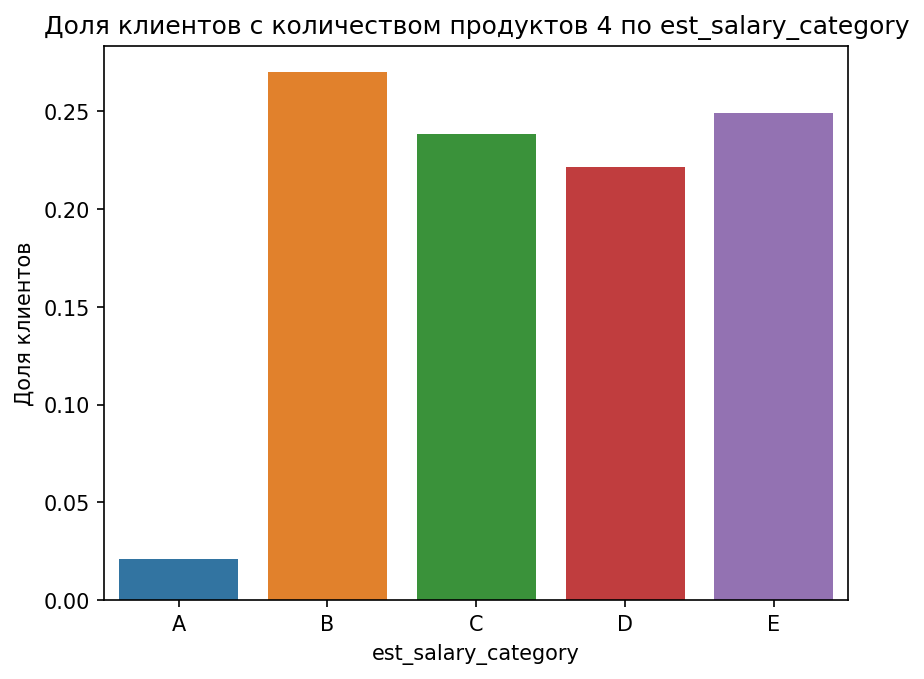

In [72]:
for column in list_of_columns:
    for products_count in [1,2,3,4]:
        df_grouped=df.query('products==@products_count').groupby(column).agg({'user_id':'count'}).assign(pct_total=(lambda x: x / x.sum()))
        df_grouped=df_grouped.reset_index()
        print(df_grouped)
        ax = sns.barplot(data=df_grouped, x=column, y='pct_total')
        plt.title(f'Доля клиентов с количеством продуктов {products_count} по {column}')
        plt.ylabel('Доля клиентов')
        plt.show()

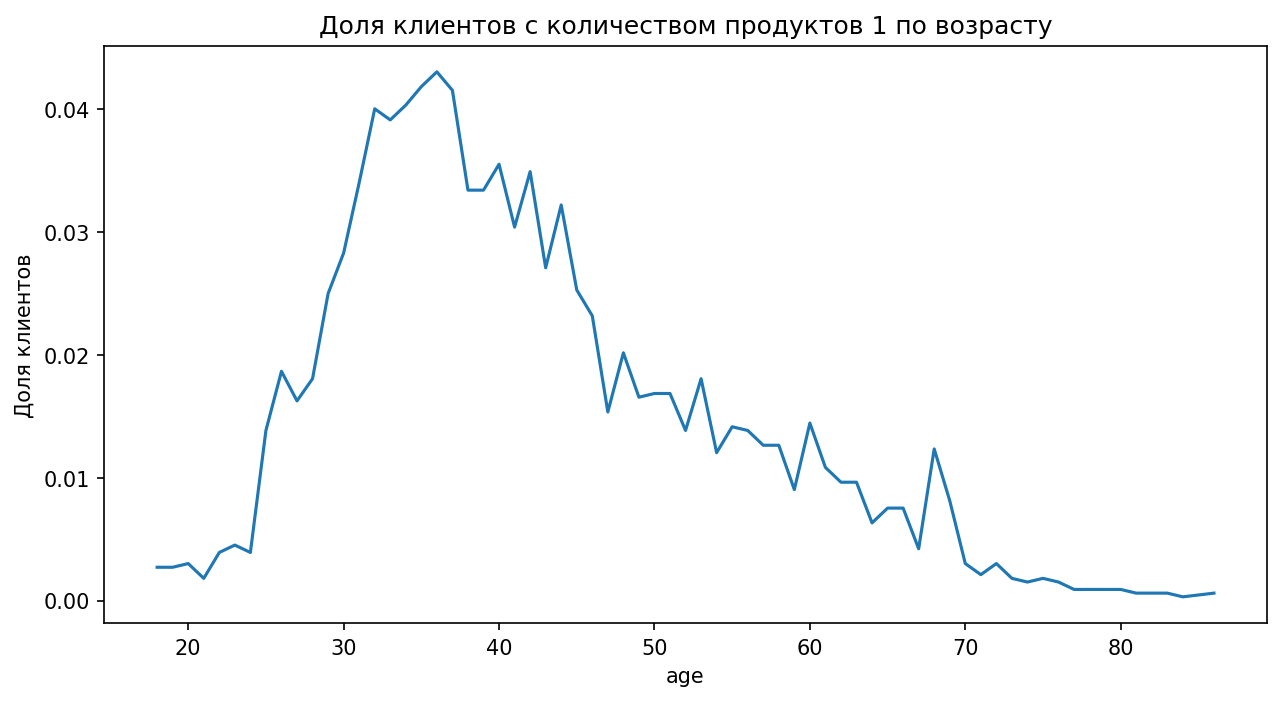

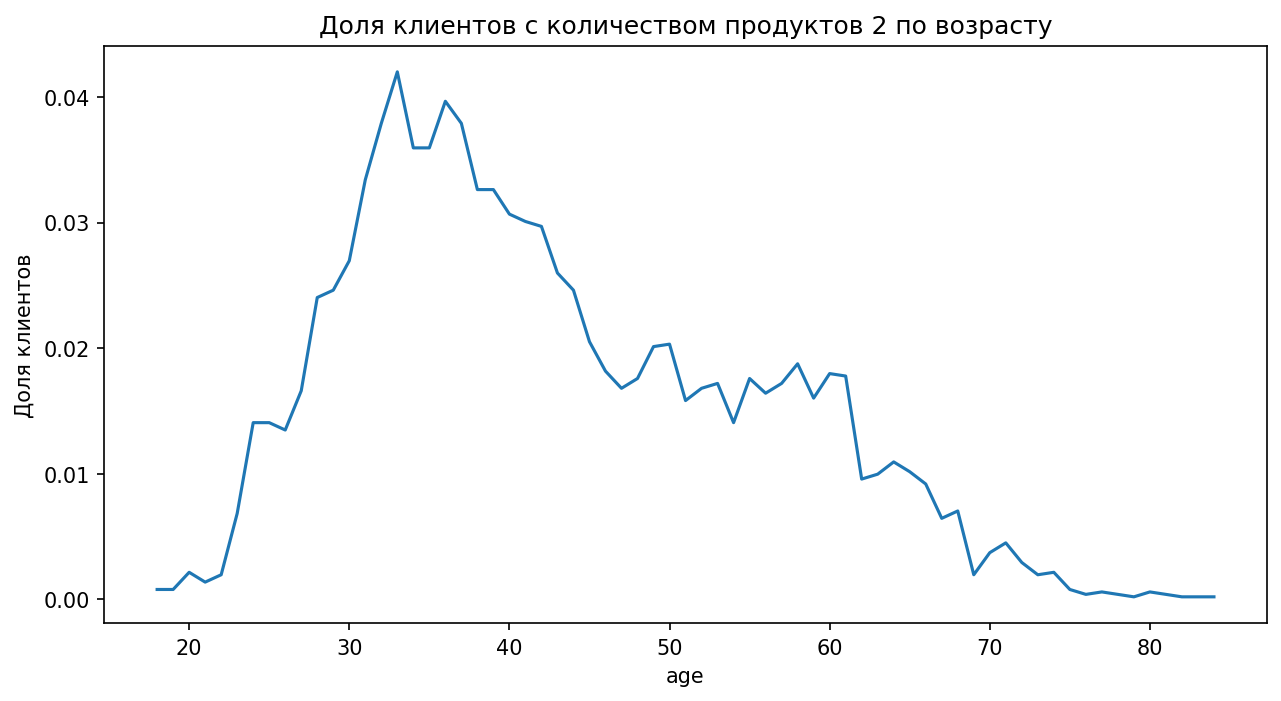

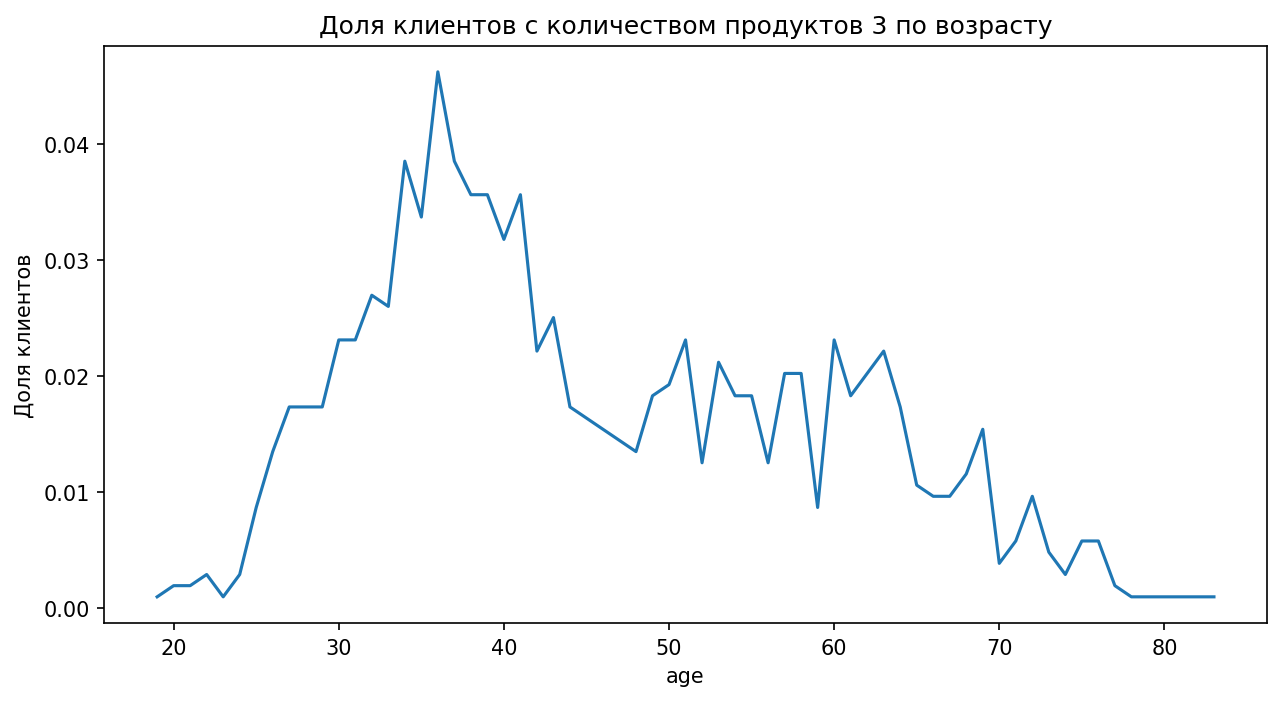

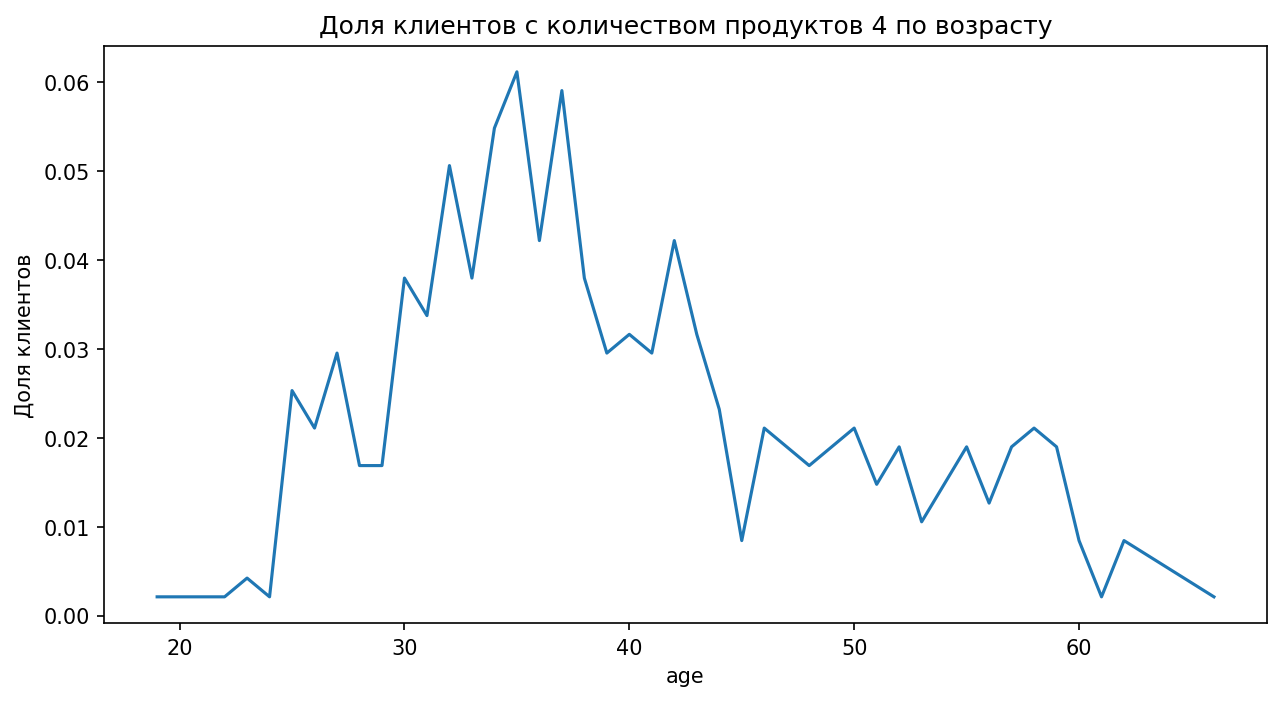

In [73]:
for products_count in [1,2,3,4]:
    df_grouped=df.query('products==@products_count').groupby('age').agg({'user_id':'count'}).assign(pct_total=(lambda x: x / x.sum())).reset_index()
            
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(data=df_grouped, x=df_grouped['age'], y=df_grouped['pct_total'])
    plt.title(f'Доля клиентов с количеством продуктов {products_count} по возрасту')
    plt.ylabel('Доля клиентов')
    plt.show()

На основе сегментации по количеству продуктов можно сделать следующие выводы:
- в Ярославле больше всего пользователей как с 1, так и с 2,3,4 продуктами
- клиенты с 1 продуктом, в 60% случаев не имеют объектов в собственности, но с увеличением количества продуктов, растет и количество объектов в собственности
- доля клиентов с кредитной картой находится в интервале 63-87%, для 1, 2 и 4 продуктов, если продуктов 3, то доля клиентов с кредитной картой значительно ниже - 36%
- доля активных клиентов снижена для 3 продуктов (42%), но высока для 4 продуктов (79%)
- доля отточных клиентов повышается с 7% для клиентов с 1 продуктом до 63% для клиентов с 4 продуктами
- распределение по полу примерно одинаковое для 1-3 продуктов, а 4 продуктами чаще пользуются мужчины (62%)
- для вех значений количества продуктов клиенты чаще всего относятся к категории В и С по score, для 3 продуктов доля категории С максимальна
- доля клиентов с категорией баланса B растет с увеличением количества продуктов
- доля клиентов с категорией E в est_salary растет с увеличением количества продуктов
- распределение по возрасту практически не зависит от количества продуктов, пик использования приходится на 30-45 лет

Рассмотрим сводную таблицу параметров для сегментов

In [74]:
df_short = df[['score', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn',
       'yaroslavl', 'rostov', 'rybinsk', 'gender_new']]

df_short.query('0<products<5').groupby('products', as_index=True).agg('mean')

score        age    equity       balance  credit_card  \
products                                                               
1         854.298114  42.196208  1.324753  6.108238e+05     0.863813   
2         844.563792  42.768900  3.151190  8.131345e+05     0.625439   
3         837.307988  45.714836  3.518768  9.940135e+05     0.356112   
4         878.267932  39.782700  4.151899  1.267821e+06     0.681435   

          last_activity     est_salary     churn  yaroslavl    rostov  \
products                                                                
1              0.528285  180731.037920  0.070338   0.608201  0.132894   
2              0.516192  130395.346490  0.190987   0.537846  0.157238   
3              0.416747  128654.951925  0.285852   0.748797  0.091434   
4              0.789030  148788.952869  0.632911   0.647679  0.143460   

           rybinsk  gender_new  
products                        
1         0.258905    0.540856  
2         0.304916    0.477175  
3         0.159769    0.430221  
4         0.208861    0.622363

Общие характеристики всех сегментов:
большинство клиентов из Ярославля
est_salary в диапазоне 130 000-180 000

Для сегментов 1,2,3:
- средний возрастов клиентов составляет 42-46 лет
- значение score  в диапазоне 837-854
активность 42-53%

Для первого сегмента характерно:
- отсутствие объектов в собственности
- наличие кредитной карты
- отток ~7%
- низкий баланс
- большая доля мужчин

Для второго сегмента характерно:
- 3 объекта в собственности
- наличие кредитной карты
- отток ~20%
- более высокий баланс
- большая доля женщин


Для третьего сегмента характерно:
- 3-4 объекта в собственности
- отсутствие кредитной карты
- отток ~30%
- более высокий баланс
- большая доля женщин


Для четвертого сегмента характерно:
- 4 объекта в собственности
- наличие кредитной карты
- активность
- отток ~63%
- высокий баланс
- большая доля мужчин
- средний возраст 38 лет

### Общий вывод

В работе исследованы данные клиентов регионального банка с целью выявления факторов оттока. 

В ходе предобработки данных названия столбцов приведены к змеиному регистру, обработаны пропуски в столбцах age и balance. Установлено

* значение balance отсутствует у пользователей со значениями score 650 - 725, а также у многих пользователей со значениями score 875 - 950
* пропуски не связаны с каким-то одним филиалом и распределены равномерно по всем филиалам в соответствии с общим количеством клиентов в каждом филиале
* пропусков больше у мужчин, хотя в общем датасете мужчин и женщин одинаковое количество
* большинство клиентов с пропусками в balance не имеет объектов в собственности
* пропуски не связаны с возрастом, наличием кредитной карт, зарплатой, активностью и оттоком

Выполнена проверка на явные и неявные дубликаты, обнаружены клиенты с одинаковым user_id из разных филиалов.

Переменные city и в gender переведены в бинарный вид, для последующего анализа.

Проведен анализ выбросов и категоризация для переменных score, balance, est_salary

Обнаружена корреляция между параметрами products и equity, products и churn, а также между est_salary и balance. 

Оказалось, что чем больше объектов в собственности, тем больше продуктов у клиента.
Проведено исследование влияния различных параметров на отток. Установлено:

* при увеличении количества объектов в собственности и продуктов отток увеличивается
* отток уменьшается с повышением параметра score и баланса на счете
* доля отточных клиентов ниже для клиентов с кредитными картами
* доля отточных клиентов выше для клиентов с недавней активностью и для мужчин
* наибольший отток в диапазонах 25-29 и 52-59 лет.

Проведена проверка гипотез, в результате которой были отвергнуты гипотезы о том, что нет разницы в возрасте между клиентами с одним и двумя продуктами и о том, что заработные платы клиентов с кредитом и без равны.

На основе сегментации по количеству продуктов установлено:
- в Ярославле больше всего пользователей как с 1, так и с 2,3 и 4 продуктами
- клиенты с 1 продуктом, в 60% случаев не имеют объектов в собственности, но с увеличением количества продуктов, растет и количество объектов в собственности
- доля клиентов с кредитной картой находится в интервале 63-87%, для 1, 2 и 4 продуктов, если продуктов 3, то доля клиентов с кредитной картой значительно ниже - 36%
- доля активных клиентов снижена для 3 продуктов (42%), но высока для 4 продуктов (79%)
- доля отточных клиентов повышается с 7% для клиентов с 1 продуктом до 63% для клиентов с 4 продуктами
- распределение по полу примерно одинаковое для 1-3 продуктов, а 4 продуктами чаще пользуются мужчины (62%)
- для всех значений количества продуктов клиенты чаще всего относятся к категории В и С по score, для 3 продуктов доля категории С максимальна
- доля клиентов с категорией баланса B растет с увеличением количества продуктов
- доля клиентов с категорией E в est_salary растет с увеличением количества продуктов
- распределение по возрасту практически не зависит от количества продуктов, пик использования приходится на 30-45 лет


Для снижения оттока можно рекомендовать предоставлять кредитные продукты, предложить лучшие условия для мужчин и клиентов в возрасте 25-30 и 45-60 лет, особые условия предложить клиентам с 3 продуктами, чтобы повысить их активность и снизить отток
Для первого сегмента можно порекомендовать, обратить внимание на привлечение женщин и клиентов в возрасте 30-40 лет,  в 4 категории больше привлекать женщин, клиентов с высоким уровнем дохода, тем самым повышать средний возраст клиентов.

Дополнение к выводам:

- для второго и третьего сегмента рекомендуется предлагать более выгодные условия по кредиту
- для четвертого сегмента предлагать выгодную программу лояльности

Для первого сегмента можно порекомендовать, обратить внимание на привлечение женщин и клиентов в возрасте 30-40 лет, для второго - предлагать более выгодные условия по кредиту, для 3 сегмента - также предложить более выгодные условия по кредиту и обратить внимание на привлечение мужчин, в 4 категории больше привлекать женщин, клиентов с высоким уровнем дохода, предлагать выгодную программу лояльности тем самым повышать средний возраст клиентов